## 1. Instalaciones necesarias

In [ ]:
! pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 15.7 MB/s eta 0:00:00


In [ ]:
import os, sys
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import pydicom
import time
import cv2
import keras
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, LeakyReLU,RandomFlip,RandomContrast,RandomBrightness, UpSampling2D,add, Input, Conv2D, Activation, Flatten, RandomRotation, RandomZoom, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import BinaryIoU
from keras.utils import plot_model
random.seed(42)
import visualkeras


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Leer los datos

In [ ]:
main_dir = '/content/drive/MyDrive/0tfm/RSNA/'

lables = 'stage_2_train_labels.csv'
lables_full = 'stage_2_detailed_class_info.csv'
images="stage_2_train_images/"


lables_dir = main_dir + lables
lables_full_dir = main_dir + lables_full
images_dir = main_dir + images
images_dir_png = main_dir + 'converted_to_png_images/'
mask_dir_png = main_dir + 'converted_to_png_mask/'
dataset_agrupado_dir =main_dir + "df_coordinates_listed.csv"

df_train_val= pd.read_csv(main_dir +"df_train_balanced.csv")
#df_test= pd.read_csv(main_dir +"df_test_sin_balancear.csv")
df_test= pd.read_csv(main_dir +"df_test_balanced.csv")
scaler = MinMaxScaler()
# Normaliza las variables numéricas en el conjunto de entrenamiento + validación
df_train_val[['PatientAge']] = scaler.fit_transform(df_train_val[['PatientAge']])
# Normaliza las variables numéricas en el conjunto de prueba utilizando los parámetros del entrenamiento
df_test[['PatientAge']] = scaler.transform(df_test[['PatientAge']])

df_train, df_val= train_test_split(df_train_val, test_size=0.2,stratify=df_train_val["Target"], random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("df_train",df_train.shape)
print("df_val", df_val.shape)
print("df_test", df_test.shape)

df_train (9122, 8)
df_val (2281, 8)
df_test (601, 8)


In [ ]:
image_size=224

def augment_image_and_mask(image, mask):
    # Aumentar el brillo de la imagen
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask


# Función para cargar imágenes
def load_image(image_path, new_size=(image_size, image_size), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

      # Redimensionar la imagen
    image = tf.image.resize(image, new_size)

        # Normalizar la imagen
    image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    return image

# Función para cargar imágenes y máscaras
def load_image_and_mask(image_path, mask_path, new_size=(image_size, image_size), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

      # Redimensionar la imagen y la máscara
    image = tf.image.resize(image, new_size)
    mask = tf.image.resize(mask, new_size)

        # Normalizar la imagen
    image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    # Normalizar la máscara binaria
    mask = tf.cast(mask, tf.float32)
    mask = tf.where(mask > 0, 1.0, 0.0)  # Convertir valores a 0 y 1

     # Aplicar data augmentation si el parámetro es 1
    if augmentation == 1:
        image, mask = augment_image_and_mask(image, mask)

    return image, mask

In [ ]:
batch_size=32

#para train
image_paths_train = images_dir_png+  df_train["filename"]  # Rutas a las imágenes de train
mask_paths_train = mask_dir_png + df_train["filename_masc"]  # Rutas a las máscaras de train
variables_num_train = df_train[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de train
target_train = df_train['Target'].values   # Objetivo binario de train

#para val
image_paths_val = images_dir_png +  df_val["filename"]  # Rutas a las imágenes de train
mask_paths_val = mask_dir_png + df_val["filename_masc"]  # Rutas a las máscaras de train
variables_num_val = df_val[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de train
target_val = df_val['Target'].values   # Objetivo binario de train

#para test
image_paths_test = images_dir_png +  df_test["filename"]  # Rutas a las imágenes de train
mask_paths_test= mask_dir_png + df_test["filename_masc"]  # Rutas a las máscaras de train
variables_num_test = df_test[["PatientAge","PatientSex","ViewPosition"]].values  # Variables adicionales de test
target_test= df_test['Target'].values  # Objetivo binario de test


con mascara y variables numericas

In [ ]:
# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, mask_paths_train, variables_num_train, target_train))
train_dataset = train_dataset.map(lambda img_path, mask_path, var, target:
                                  ((load_image_and_mask(img_path, mask_path, augmentation=0)[0], var),  # Entrada: imagen y variables
                                   (load_image_and_mask(img_path, mask_path, augmentation=0)[1], target)))  # Salida: máscara y target
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()  # Repetir indefinidamente para evitar quedarse sin datos
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)  # Optimizar la carga de datos

# Dataset de val
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths_val, mask_paths_val, variables_num_val, target_val))
val_dataset = val_dataset.map(lambda img_path, mask_path, var, target:
                                ((load_image_and_mask(img_path, mask_path, augmentation=0)[0], var),  # Entrada: imagen y variables
                                 (load_image_and_mask(img_path, mask_path, augmentation=0)[1], target)))  # Salida: máscara y target
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()  # Repetir indefinidamente
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Dataset de prueba (test)
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, mask_paths_test, variables_num_test, target_test))
test_dataset = test_dataset.map(lambda img_path, mask_path, var, target:
                                ((load_image_and_mask(img_path, mask_path, augmentation=0)[0], var),  # Entrada: imagen y variables
                                 (load_image_and_mask(img_path, mask_path, augmentation=0)[1], target)))  # Salida: máscara y target
test_dataset = test_dataset.batch(batch_size)

 Visualizar las curvas de aprendizaje (loss y métricas)

In [ ]:
def plot_learning_curves(history, type_g=1):
    # Graficar la pérdida (loss)
    plt.figure(figsize=(12, 4))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()


    # Métricas para la salida de target binario
    plt.subplot(1, 3, 2)
    if type_g == 1:
      plt.plot(history['accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_accuracy'], label='Accuracy de validación')
    elif type_g == 2:
      plt.plot(history['target_output_accuracy'], label='Accuracy de entrenamiento')
      plt.plot(history['val_target_output_accuracy'], label='Accuracy de validación')
    plt.title('Accuracy del target binario')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    plt.subplot(1, 3, 3)
    if type_g == 1:
      plt.plot(history.iloc[:,4], label='Accuracy de entrenamiento')
      plt.plot(history.iloc[:,9], label='Accuracy de validación')
      plt.title('Recall del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('recall')
      plt.legend()
      plt.ylim(0, 1)
    elif type_g == 2:
      plt.plot(history.iloc[:,1], label='IoU de entrenamiento')
      plt.plot(history.iloc[:,7], label='IoU de validación')
      plt.title('IoU del target binario')
      plt.xlabel('Épocas')
      plt.ylabel('IoU')
      plt.legend()
      plt.ylim(0, 1)

    plt.show()



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,  # Número de epochs sin mejora antes de detener el entrenamiento
                               restore_best_weights=True)  # Para restaurar los pesos del modelo con la mejor pérdida
# Definir ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,     # Reducir el learning rate en un 20%
                              patience=2,     # Esperar 3 épocas sin mejora
                              min_lr=1e-8)    # No reducir el learning rate por debajo de 1e-8


 Comparar modelos de segmentacion

In [ ]:
# Función para extraer métricas de la última época
def unet_extract_last_epoch_metrics(history_df):
    last_epoch = history_df.iloc[-1]
    return {
        'Loss': last_epoch.iloc[6],
        'Accuracy': last_epoch.iloc[8],
        'Precision': last_epoch.iloc[10],
        'Recall': last_epoch.iloc[11],
        'AUC': last_epoch.iloc[9],
        'IoU': last_epoch.iloc[7]
    }

def unet_comparar_modelos(lista_history_files):

    # Lista de archivos de historial
    lista_history_files = lista_history_files
    lista_metrics = []

    # Extraer métricas para cada modelo
    for item in lista_history_files:
        history_df = pd.read_csv(main_dir + "model_training/" + item)
        metrics = unet_extract_last_epoch_metrics(history_df)
        metrics['Model'] = item  # Añadir el nombre del modelo a las métricas
        lista_metrics.append(metrics)

    # Crear un DataFrame a partir de las métricas
    metrics_df = pd.DataFrame(lista_metrics)

    # Mostrar el DataFrame con las métricas
    print(metrics_df)
    for item in lista_history_files:

        history_df = pd.read_csv(main_dir + "model_training/" + item)
        print(item)
        plot_learning_curves(history_df,2)

## Modelos

### Priorizar la tarea durante el entrenamiento: clasificación o segmentación

In [ ]:
def create_unet_2():  # Reducir tamaño de entrada
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6  = Conv2DTranspose(256, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(128, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)


    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name ="mask_output")(conv9)

    # No se utilizará la entrada de variables adicionales para el objetivo binario
    # Simplemente se creará una salida para la máscara.

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(conv9)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)


    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_2()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 224, 224, 32)   │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 224, 224, 32)   │            128 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 112, 112, 64)   │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 112, 112, 64)   │            256 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 56, 56, 128)    │            512 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 56, 56, 128)    │            512 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 8,166,786 (31.15 MB)

 Trainable params: 8,164,866 (31.15 MB)

 Non-trainable params: 1,920 (7.50 KB)

#### U-Net-M3-T7

{'mask_output': 0.3, 'target_output': 0.7}

In [ ]:
model = create_unet_2()

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.3, 'target_output': 0.7})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_5.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_5.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 1537s 5s/step - loss: 0.5250 - mask_output_binary_io_u: 0.3045 - target_output_accuracy: 0.6255 - target_output_auroc: 0.6562 - target_output_precision: 0.6232 - target_output_recall: 0.6392 - val_loss: 1.7574 - val_mask_output_binary_io_u: 0.3561 - val_target_output_accuracy: 0.4996 - val_target_output_auroc: 0.4424 - val_target_output_precision: 0.5000 - val_target_output_recall: 0.0018 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 206s 667ms/step - loss: 0.5081 - mask_output_binary_io_u: 0.3111 - target_output_accuracy: 0.6580 - target_output_auroc: 0.7047 - target_output_precision: 0.6558 - target_output_recall: 0.6720 - val_loss: 0.4790 - val_mask_output_binary_io_u: 0.3566 - val_target_output_accuracy: 0.6834 - val_target_output_auroc: 0.7661 - val_target_output_precision: 0.6377 - val_target_output_recall: 0.8527 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 194s 682ms/step - loss: 0.4637 - mask_output_b

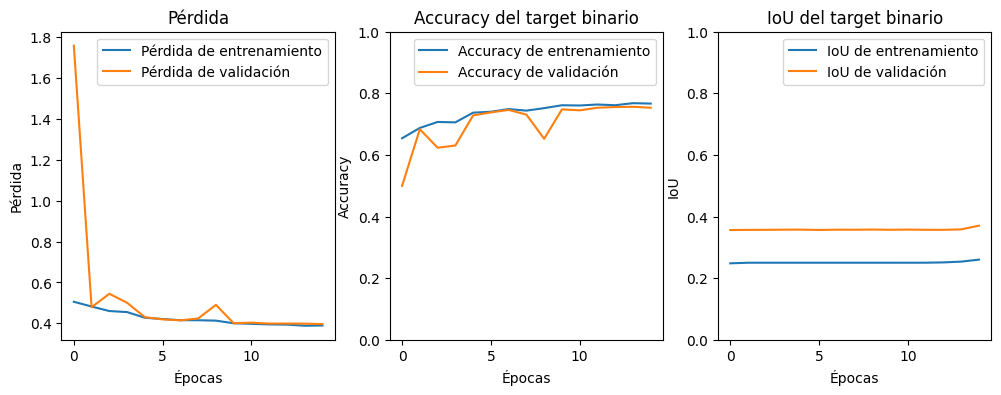

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_5.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-M7-T3

{'mask_output': 0.7, 'target_output': 0.3}

In [ ]:
model = create_unet_2()

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_2.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_2.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2015s 6s/step - loss: 0.3327 - mask_output_binary_io_u: 0.3061 - target_output_accuracy: 0.6221 - target_output_auroc: 0.6708 - target_output_precision: 0.6271 - target_output_recall: 0.6038 - val_loss: 0.6308 - val_mask_output_binary_io_u: 0.3561 - val_target_output_accuracy: 0.4996 - val_target_output_auroc: 0.7298 - val_target_output_precision: 0.0000e+00 - val_target_output_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 214s 693ms/step - loss: 0.2889 - mask_output_binary_io_u: 0.3130 - target_output_accuracy: 0.7112 - target_output_auroc: 0.7740 - target_output_precision: 0.7195 - target_output_recall: 0.7017 - val_loss: 0.3203 - val_mask_output_binary_io_u: 0.3566 - val_target_output_accuracy: 0.6358 - val_target_output_auroc: 0.6999 - val_target_output_precision: 0.6301 - val_target_output_recall: 0.6619 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 197s 691ms/step - loss: 0.2702 - mask_

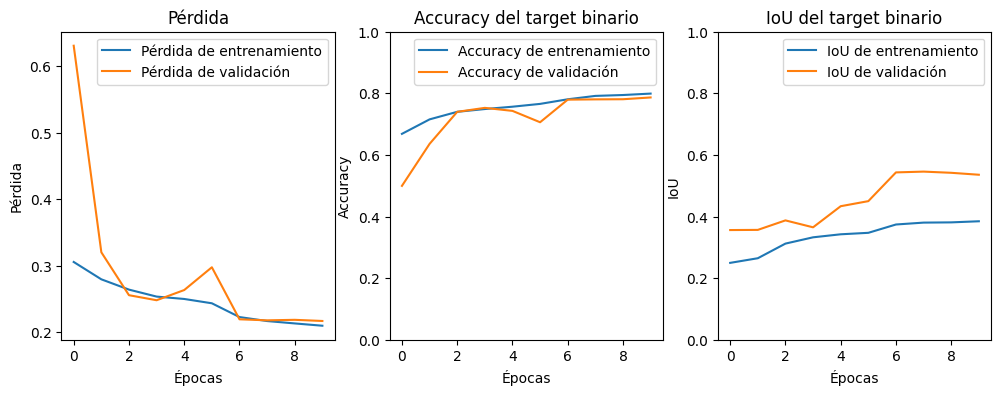

In [ ]:
#con balanceo
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_2.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-M9-T1

{'mask_output': 0.9, 'target_output': 0.1}

In [ ]:
model = create_unet_2()

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.9, 'target_output': 0.1})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_6.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_6.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 211s 658ms/step - loss: 0.2542 - mask_output_binary_io_u_1: 0.2969 - target_output_accuracy: 0.5500 - target_output_auroc: 0.5715 - target_output_precision_1: 0.5555 - target_output_recall_1: 0.4796 - val_loss: 0.2246 - val_mask_output_binary_io_u_1: 0.3561 - val_target_output_accuracy: 0.6105 - val_target_output_auroc: 0.7883 - val_target_output_precision_1: 0.8865 - val_target_output_recall_1: 0.2542 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 199s 664ms/step - loss: 0.1861 - mask_output_binary_io_u_1: 0.3888 - target_output_accuracy: 0.7240 - target_output_auroc: 0.7805 - target_output_precision_1: 0.7298 - target_output_recall_1: 0.7135 - val_loss: 0.4453 - val_mask_output_binary_io_u_1: 0.3566 - val_target_output_accuracy: 0.5064 - val_target_output_auroc: 0.4815 - val_target_output_precision_1: 0.6735 - val_target_output_recall_1: 0.0293 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 193s 676ms/step - lo

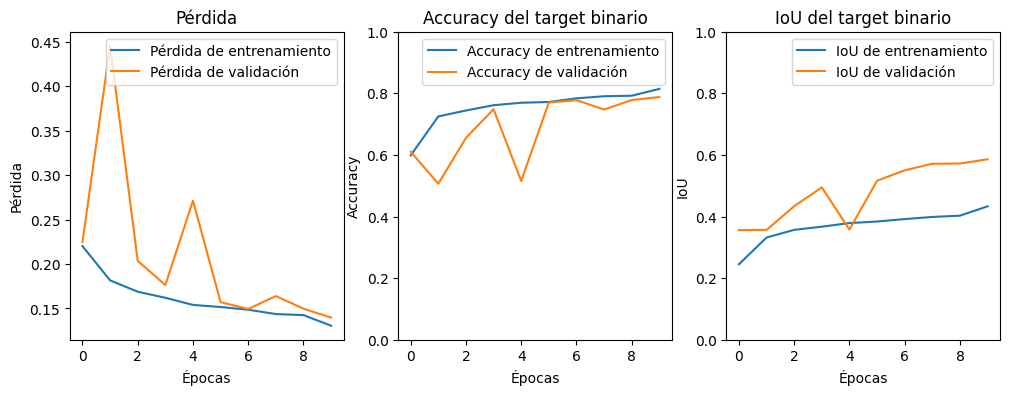

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_6.csv')
plot_learning_curves(history_df_csv,2)

#### Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.396288  0.753224   0.747598  0.762923  0.838074  0.370260   
1  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
2  0.139760  0.787906   0.757744  0.847247  0.876081  0.585851   

                  Model  
0  history_0_unet_5.csv  
1  history_0_unet_2.csv  
2  history_0_unet_6.csv  
history_0_unet_5.csv


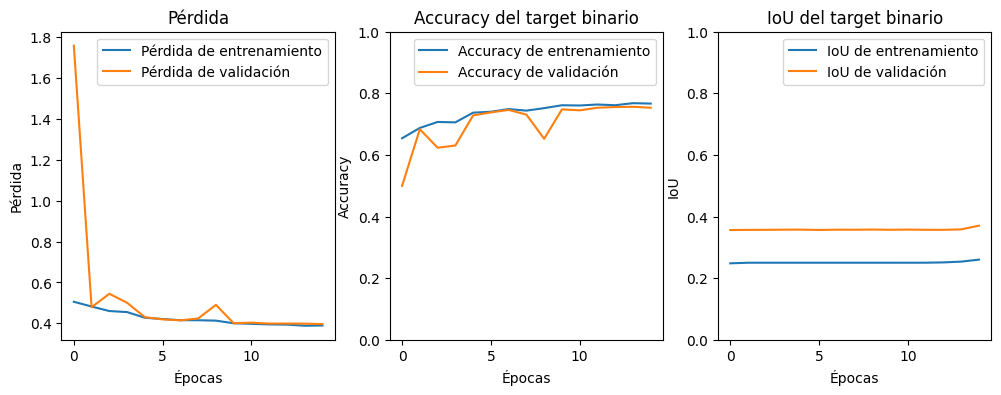

history_0_unet_2.csv


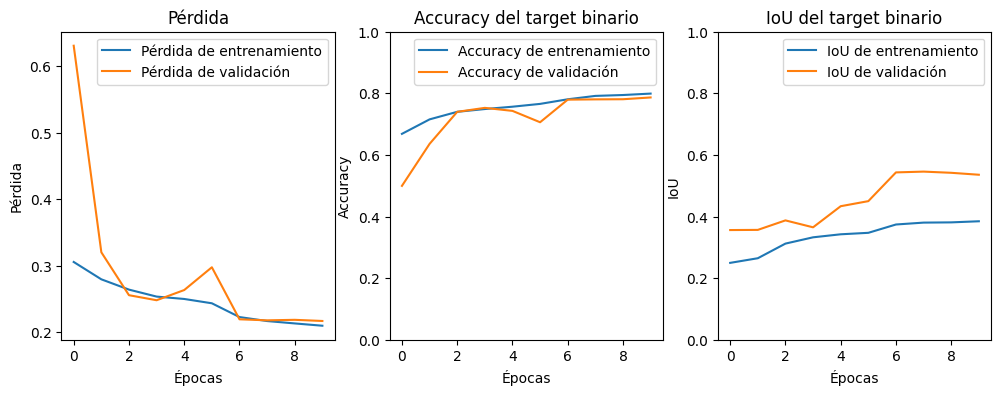

history_0_unet_6.csv


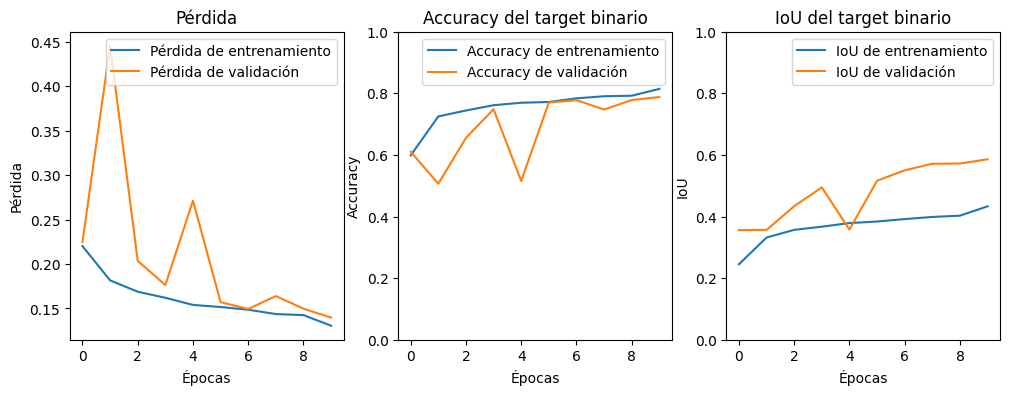

In [ ]:
#profundidad?
lista_history_files =[
                      'history_0_unet_5.csv', # U-Net-M3-T7
                      'history_0_unet_2.csv',  # U-Net-M7-T3
                      'history_0_unet_6.csv' #U-Net-M9-T1


]
unet_comparar_modelos(lista_history_files)

### Profundidad del modelo U-Net

#### U-Net-D2

In [ ]:
def create_unet_shallow():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)

    # Decoder
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)

    up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization(momentum=0.9)(conv5)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name='mask_output')(conv5)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(conv5)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_shallow()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 224, 224, 32)   │            128 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 112, 112, 64)   │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 56, 56, 128)    │            512 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 112, 112, 64)   │         32,832 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 112, 112, 128)  │              0 │ batch_normalization_1… │
│ (Concatenate)             │                        │                │ conv2d_transpose_5[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 64)   │         73,792 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 224, 224, 32)   │          8,224 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6        

 Total params: 230,050 (898.63 KB)

 Trainable params: 229,410 (896.13 KB)

 Non-trainable params: 640 (2.50 KB)

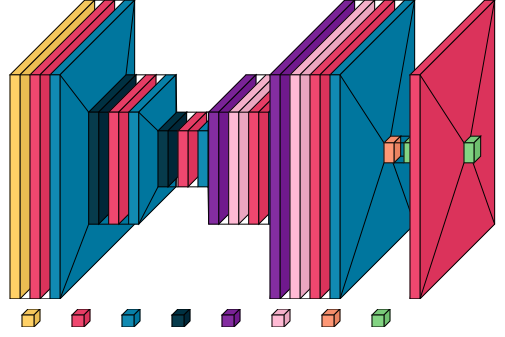

In [ ]:
visualkeras.layered_view(model, legend=True,  scale_xy=1, scale_z=1, max_z=10)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_shalow.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_shalow.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 99s 291ms/step - loss: 0.5464 - mask_output_binary_io_u_2: 0.2486 - target_output_accuracy: 0.6515 - target_output_auroc: 0.6894 - target_output_precision_2: 0.6494 - target_output_recall_2: 0.6463 - val_loss: 0.3281 - val_mask_output_binary_io_u_2: 0.3561 - val_target_output_accuracy: 0.6739 - val_target_output_auroc: 0.7522 - val_target_output_precision_2: 0.6274 - val_target_output_recall_2: 0.8575 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - loss: 0.3013 - mask_output_binary_io_u_2: 0.3198 - target_output_accuracy: 0.7146 - target_output_auroc: 0.7856 - target_output_precision_2: 0.7099 - target_output_recall_2: 0.7361 - val_loss: 0.3700 - val_mask_output_binary_io_u_2: 0.3566 - val_target_output_accuracy: 0.5580 - val_target_output_auroc: 0.7547 - val_target_output_precision_2: 0.5318 - val_target_output_recall_2: 0.9876 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 285ms/step - loss:

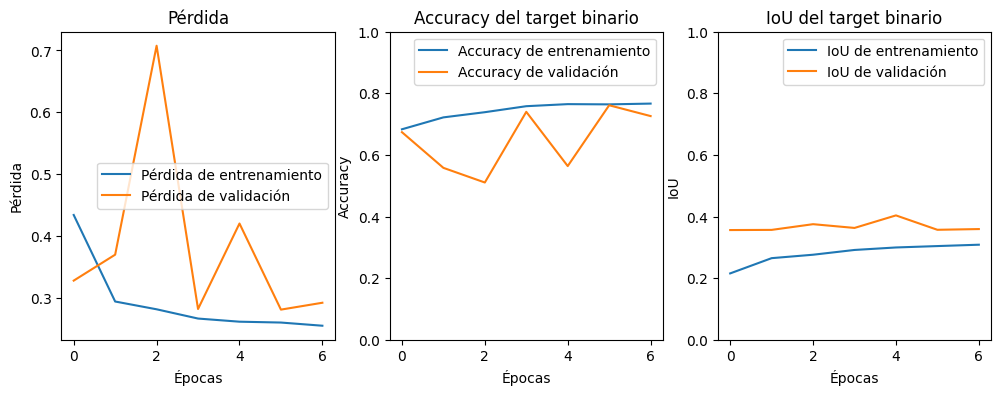

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_shalow.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-D4

Mira  Unet {'mask_output': 0.7, 'target_output': 0.3}

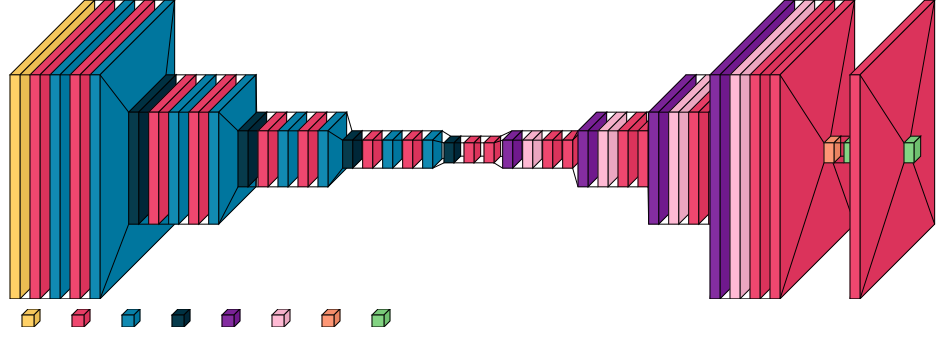

In [ ]:
visualkeras.layered_view(model, legend=True,  scale_xy=1, scale_z=1, max_z=10)

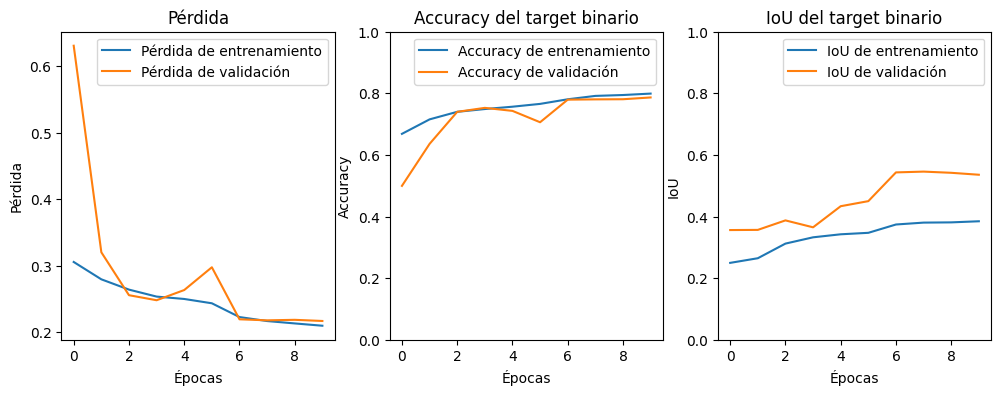

In [ ]:
#con balanceo
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_2.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-D5

In [ ]:
def create_unet_deep():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization(momentum=0.9)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization(momentum=0.9)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv5)

    # Bottleneck
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
    drop6 = Dropout(0.5)(conv6)

    # Decoder
    up7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', activation='relu')(drop6)
    merge7 = concatenate([conv5, up7], axis=3)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization(momentum=0.9)(conv7)

    up8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv7)
    merge8 = concatenate([conv4, up8], axis=3)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization(momentum=0.9)(conv8)

    up9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv8)
    merge9 = concatenate([conv3, up9], axis=3)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization(momentum=0.9)(conv9)

    up10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv9)
    merge10 = concatenate([conv2, up10], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge10)
    conv10 = BatchNormalization(momentum=0.9)(conv10)

    up11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv10)
    merge11 = concatenate([conv1, up11], axis=3)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge11)
    conv11 = BatchNormalization(momentum=0.9)(conv11)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name='mask_output')(conv11)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(conv11)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_deep()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 56, 56, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 27,964,930 (106.68 MB)

 Trainable params: 27,958,978 (106.66 MB)

 Non-trainable params: 5,952 (23.25 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


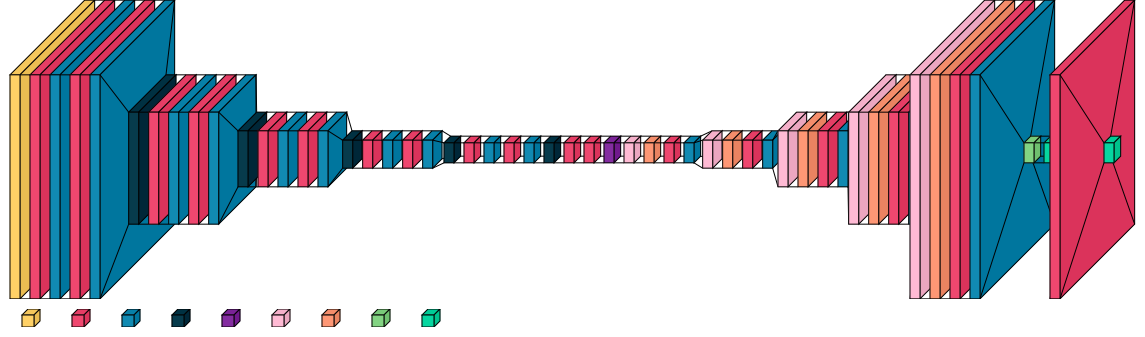

In [ ]:
visualkeras.layered_view(model, legend=True,  scale_xy=1, scale_z=1, max_z=10)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_deep.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_deep.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 184s 513ms/step - loss: 0.5240 - mask_output_binary_io_u_3: 0.2952 - target_output_accuracy: 0.6608 - target_output_auroc: 0.7190 - target_output_precision_3: 0.6580 - target_output_recall_3: 0.6627 - val_loss: 0.2891 - val_mask_output_binary_io_u_3: 0.3943 - val_target_output_accuracy: 0.7236 - val_target_output_auroc: 0.7974 - val_target_output_precision_3: 0.7173 - val_target_output_recall_3: 0.7388 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 156s 500ms/step - loss: 0.2789 - mask_output_binary_io_u_3: 0.3827 - target_output_accuracy: 0.7395 - target_output_auroc: 0.8004 - target_output_precision_3: 0.7375 - target_output_recall_3: 0.7471 - val_loss: 0.2735 - val_mask_output_binary_io_u_3: 0.4808 - val_target_output_accuracy: 0.7368 - val_target_output_auroc: 0.8086 - val_target_output_precision_3: 0.7353 - val_target_output_recall_3: 0.7418 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 144s 507ms/step - lo

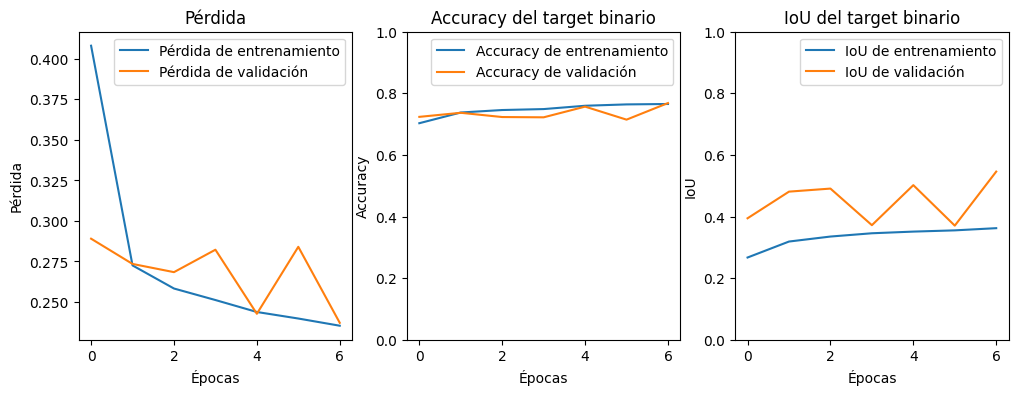

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" + 'history_0_unet_deep.csv')
plot_learning_curves(history_df_csv,2)

#### Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.292297  0.726101   0.803851  0.595897  0.832157  0.359276   
1  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
2  0.237198  0.768341   0.759516  0.783229  0.844985  0.545902   

                       Model  
0  history_0_unet_shalow.csv  
1       history_0_unet_2.csv  
2    history_0_unet_deep.csv  
history_0_unet_shalow.csv


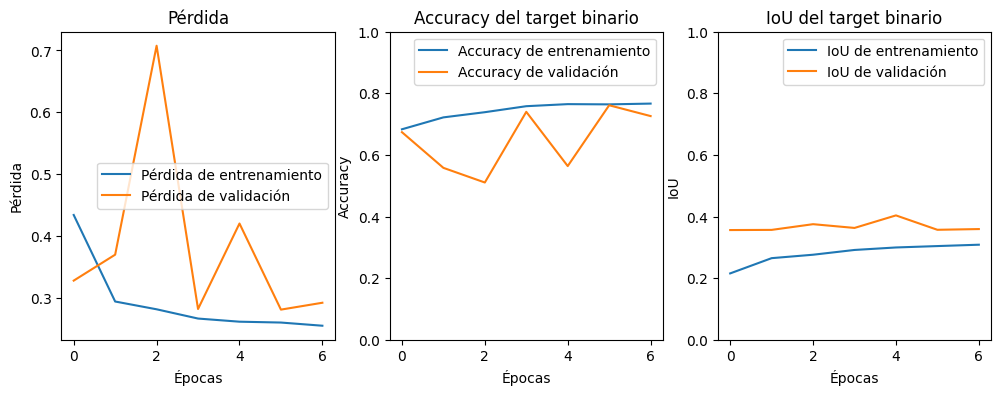

history_0_unet_2.csv


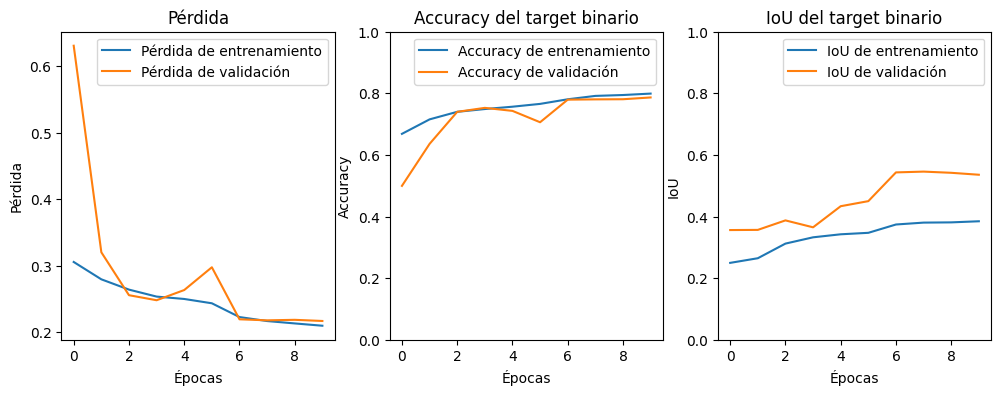

history_0_unet_deep.csv


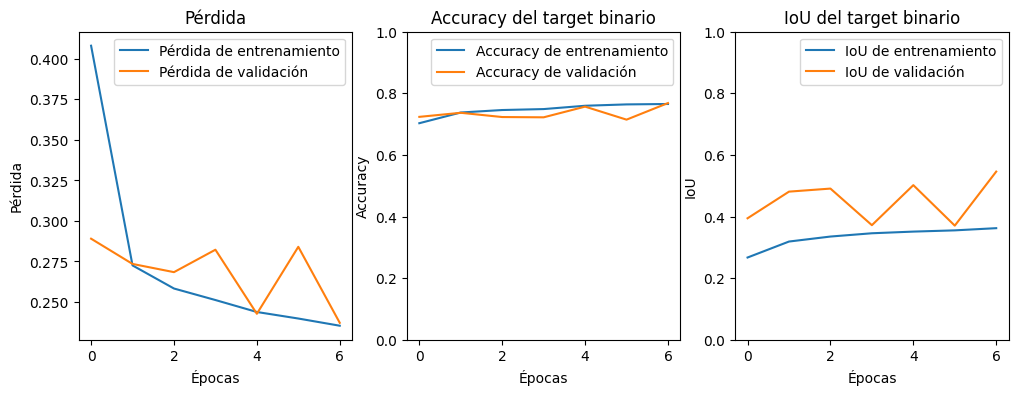

In [ ]:
#profundidad?
lista_history_files =[
                      'history_0_unet_shalow.csv', # U-Net-D2
                      'history_0_unet_2.csv',  # U-Net-D3
                      'history_0_unet_deep.csv' # U-Net-D4


]
unet_comparar_modelos(lista_history_files)

### Variantes de Decoders en U-Net: Conv2DTranspose y UpSampling2D

#### U-Net-Decod

In [ ]:
def create_up_sampling():  # Reducir tamaño de entrada
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6  = Conv2DTranspose(256, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)


    last_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    # Salida para la máscara
    mask_output = UpSampling2D(4, name ="mask_output")(last_layer)


    # No se utilizará la entrada de variables adicionales para el objetivo binario
    # Simplemente se creará una salida para la máscara.

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(last_layer)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)


    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_up_sampling()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 224, 224, 32)   │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 224, 224, 32)   │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 112, 112, 64)   │            256 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 112, 112, 64)   │            256 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 56, 56, 128)    │            512 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 56, 56, 128)    │            512 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,863,394 (30.00 MB)

 Trainable params: 7,861,474 (29.99 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_upp_sample.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_upp_sample.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - loss: 0.3332 - mask_output_binary_io_u_1: 0.3114 - target_output_accuracy: 0.5656 - target_output_auroc: 0.6134 - target_output_precision_1: 0.5537 - target_output_recall_1: 0.6330 - val_loss: 0.2977 - val_mask_output_binary_io_u_1: 0.4797 - val_target_output_accuracy: 0.7091 - val_target_output_auroc: 0.7907 - val_target_output_precision_1: 0.6657 - val_target_output_recall_1: 0.8408 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 350ms/step - loss: 0.2866 - mask_output_binary_io_u_1: 0.4526 - target_output_accuracy: 0.7275 - target_output_auroc: 0.7859 - target_output_precision_1: 0.7051 - target_output_recall_1: 0.7929 - val_loss: 0.2868 - val_mask_output_binary_io_u_1: 0.4804 - val_target_output_accuracy: 0.7048 - val_target_output_auroc: 0.7924 - val_target_output_precision_1: 0.7714 - val_target_output_recall_1: 0.5839 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 98s 343ms/step - loss: 

#### U-Net-UP

In [ ]:
def create_up_sampling_total():  # Reducir tamaño de entrada
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Up-sampling en lugar del decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)  # Up-sampling
    up6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    up6 = BatchNormalization(momentum=0.9)(up6)

    up7 = UpSampling2D(size=(2, 2))(up6)  # Up-sampling
    up7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    up7 = BatchNormalization(momentum=0.9)(up7)

    # Última capa de convolución para la salida de la máscara
    last_layer = Conv2D(1, (1, 1), activation='sigmoid')(up7)
    # Salida para la máscara
    mask_output = UpSampling2D(4, name="mask_output")(last_layer)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(last_layer)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_up_sampling_total()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 224, 224, 32)   │            128 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 224, 224, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 64)   │            256 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 64)   │            256 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 128)    │            512 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 56, 56, 128)    │            512 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 6,192,866 (23.62 MB)

 Trainable params: 6,190,178 (23.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_upp_total.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_upp_total.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 122s 324ms/step - loss: 0.5056 - mask_output_binary_io_u_2: 0.2915 - target_output_accuracy: 0.5060 - target_output_auroc: 0.5022 - target_output_precision_2: 0.4139 - target_output_recall_2: 0.4787 - val_loss: 0.3065 - val_mask_output_binary_io_u_2: 0.5141 - val_target_output_accuracy: 0.6681 - val_target_output_auroc: 0.7788 - val_target_output_precision_2: 0.6111 - val_target_output_recall_2: 0.9261 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 99s 315ms/step - loss: 0.3000 - mask_output_binary_io_u_2: 0.4345 - target_output_accuracy: 0.6395 - target_output_auroc: 0.7798 - target_output_precision_2: 0.5927 - target_output_recall_2: 0.9264 - val_loss: 0.2951 - val_mask_output_binary_io_u_2: 0.4764 - val_target_output_accuracy: 0.7314 - val_target_output_auroc: 0.8056 - val_target_output_precision_2: 0.7566 - val_target_output_recall_2: 0.6841 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 89s 312ms/step - loss

#### Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
1  0.225119  0.788795   0.774221  0.816163  0.870822  0.564954   
2  0.226680  0.767008   0.829107  0.670830  0.867382  0.558577   

                      Model  
0      history_0_unet_2.csv  
1  history_0_upp_sample.csv  
2   history_0_upp_total.csv  
history_0_unet_2.csv


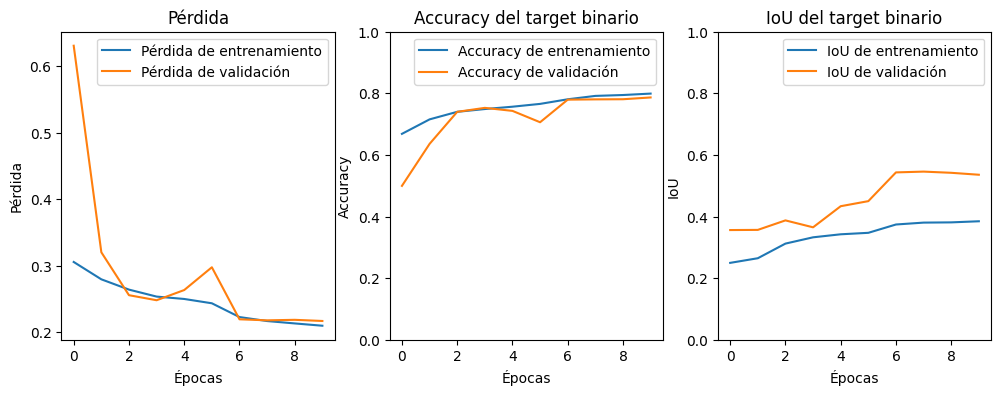

history_0_upp_sample.csv


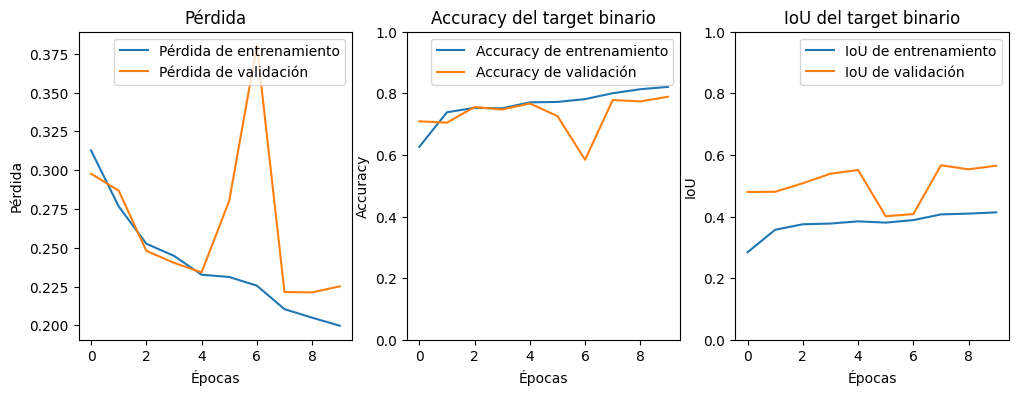

history_0_upp_total.csv


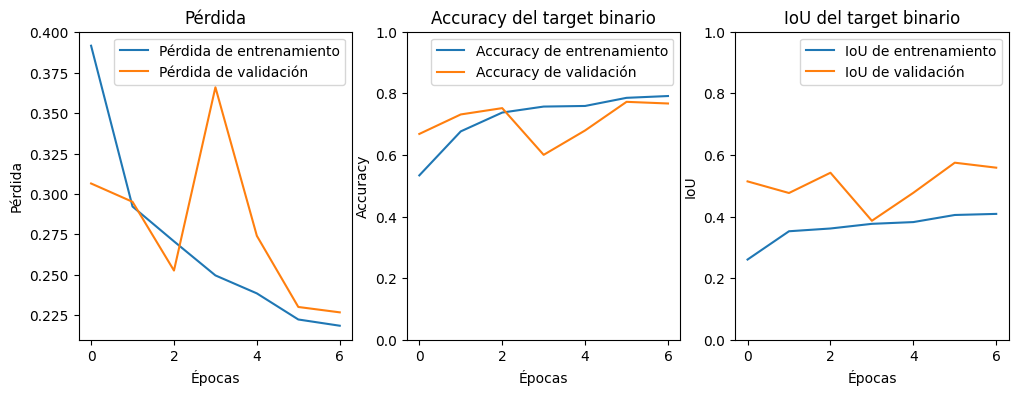

In [ ]:
#profundidad?
lista_history_files =[
                      'history_0_unet_2.csv',  # U-Net-Decod
                      'history_0_upp_total.csv' # U-Net-UP
]
unet_comparar_modelos(lista_history_files)

### Bloques Residuales y función de activación

#### U-Net

In [ ]:
model = create_unet_2()

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_2.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_2.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2015s 6s/step - loss: 0.3327 - mask_output_binary_io_u: 0.3061 - target_output_accuracy: 0.6221 - target_output_auroc: 0.6708 - target_output_precision: 0.6271 - target_output_recall: 0.6038 - val_loss: 0.6308 - val_mask_output_binary_io_u: 0.3561 - val_target_output_accuracy: 0.4996 - val_target_output_auroc: 0.7298 - val_target_output_precision: 0.0000e+00 - val_target_output_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 214s 693ms/step - loss: 0.2889 - mask_output_binary_io_u: 0.3130 - target_output_accuracy: 0.7112 - target_output_auroc: 0.7740 - target_output_precision: 0.7195 - target_output_recall: 0.7017 - val_loss: 0.3203 - val_mask_output_binary_io_u: 0.3566 - val_target_output_accuracy: 0.6358 - val_target_output_auroc: 0.6999 - val_target_output_precision: 0.6301 - val_target_output_recall: 0.6619 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 197s 691ms/step - loss: 0.2702 - mask_

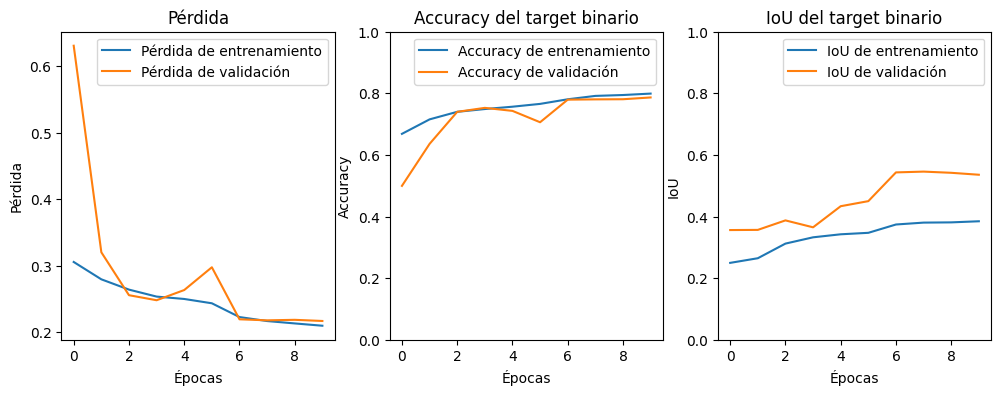

In [ ]:
#con balanceo
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_2.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-Res

In [ ]:
def residual_block(input, n_filters):
    # Normalización de la entrada
    res = BatchNormalization()(input)
    # Primera convolución
    res = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(res)
    res = BatchNormalization()(res)
    # Segunda convolución
    res = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(res)
    res = BatchNormalization()(res)
    # Suma de la entrada original con la salida de las capas convolucionales
    res = Add()([res, input ])

    # Activación final (en este caso no necesitas más activación ya que cada convolución tiene 'relu')
    return res

In [ ]:
def create_res_unet():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, pero no se usará en el modelo

    # Encoder con bloques residuales
    conv0 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_im)
    conv0 = BatchNormalization()(conv0)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv0)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block(pool1, 32)


    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(res1)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block(pool2, 64)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(res2)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block(pool3, 128)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(res3)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, kernel_size = (2,2), padding = 'same', activation = 'relu', strides = 2)(drop5)
    merge6 = concatenate([conv4, up6], axis=3)  #merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block(merge6, 512) #256

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(res6)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block(merge7, 256)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(res7)
    merge8 = concatenate([conv2, up8], axis=3)
    res8 = residual_block(merge8, 128)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(res8)
    merge9 = concatenate([conv1, up9], axis=3)
    res9 = residual_block(merge9, 64)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(res9)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(res9)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model

# Crear el modelo
model = create_res_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 11,483,458 (43.81 MB)

 Trainable params: 11,475,266 (43.77 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [ ]:
epochs = 20
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_3.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_3.csv', index=False)

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1552s 4s/step - loss: 0.3279 - mask_output_binary_io_u: 0.3160 - target_output_accuracy: 0.6786 - target_output_auroc: 0.7402 - target_output_precision: 0.6736 - target_output_recall: 0.6699 - val_loss: 0.9429 - val_mask_output_binary_io_u: 0.3308 - val_target_output_accuracy: 0.5207 - val_target_output_auroc: 0.6594 - val_target_output_precision: 0.5109 - val_target_output_recall: 0.9921 - learning_rate: 0.0010
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 260s 836ms/step - loss: 0.2682 - mask_output_binary_io_u: 0.3934 - target_output_accuracy: 0.7325 - target_output_auroc: 0.7985 - target_output_precision: 0.7254 - target_output_recall: 0.7525 - val_loss: 0.4050 - val_mask_output_binary_io_u: 0.4353 - val_target_output_accuracy: 0.6434 - val_target_output_auroc: 0.8167 - val_target_output_precision: 0.5869 - val_target_output_recall: 0.9734 - learning_rate: 0.0010
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 239s 840ms/step - loss: 0.2453 - mask_output_b

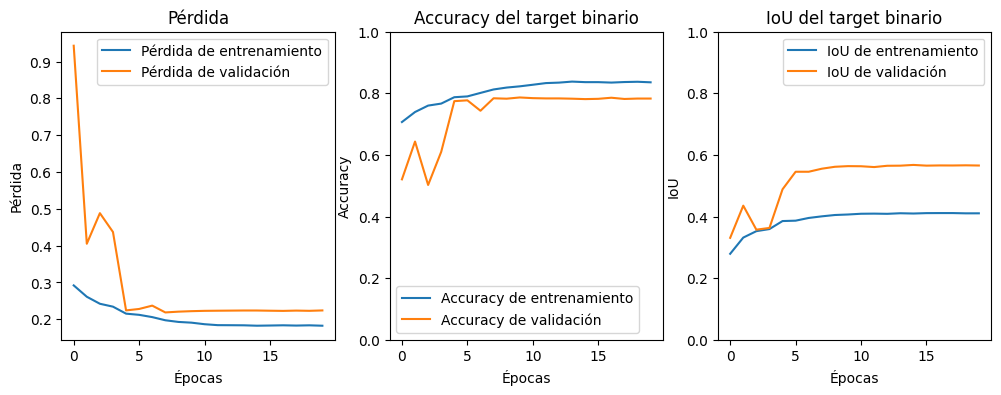

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_3.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-Res-Leaky

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def residual_block_leaky(input, n_filters):
    # Normalización de la entrada
    res = BatchNormalization()(input)
    # Primera convolución sin bias y sin activación
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    # Segunda convolución sin bias y sin activación
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    # Suma de la entrada original con la salida de las capas convolucionales
    res = Add()([res, input])
    # Activación final con Leaky ReLU
    res = LeakyReLU(alpha=0.1)(res)
    return res

In [ ]:
def create_res_unet_leaky_relu():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, no utilizada en el modelo

    # Encoder con bloques residuales
    conv0 = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_im)
    conv0 = BatchNormalization()(conv0)
    conv0 = LeakyReLU(alpha=0.1)(conv0)

    conv1 = Conv2D(32, (3, 3), padding='same', use_bias=False)(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block_leaky(pool1, 32)

    conv2 = Conv2D(64, (3, 3), padding='same', use_bias=False)(res1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block_leaky(pool2, 64)

    conv3 = Conv2D(128, (3, 3), padding='same', use_bias=False)(res2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block_leaky(pool3, 128)

    conv4 = Conv2D(256, (3, 3), padding='same', use_bias=False)(res3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block_leaky(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(drop5)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(alpha=0.1)(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block_leaky(merge6, 512)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res6)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(alpha=0.1)(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block_leaky(merge7, 256)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res7)
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.1)(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    res8 = residual_block_leaky(merge8, 128)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res8)
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=0.1)(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    res9 = residual_block_leaky(merge9, 64)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(res9)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(res9)
    dense = Dense(64, use_bias=False)(flatten)
    dense = BatchNormalization()(dense)
    dense = LeakyReLU(alpha=0.1)(dense)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model

# Crear el modelo con Leaky ReLU y sin bias
model = create_res_unet_leaky_relu()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 224, 224, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,216 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 224, 224, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │          9,216 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │          9,216 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_4… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 112, 112, 32)   │              0 │ add[0][0]              │
├──────────────────────

 Total params: 11,485,154 (43.81 MB)

 Trainable params: 11,473,890 (43.77 MB)

 Non-trainable params: 11,264 (44.00 KB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_4.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_4.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 315s 805ms/step - loss: 0.3311 - mask_output_binary_io_u: 0.3092 - target_output_accuracy: 0.6739 - target_output_auroc: 0.7423 - target_output_precision: 0.7022 - target_output_recall: 0.5988 - val_loss: 3.4386 - val_mask_output_binary_io_u: 0.3885 - val_target_output_accuracy: 0.5004 - val_target_output_auroc: 0.6101 - val_target_output_precision: 0.5004 - val_target_output_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 259s 820ms/step - loss: 0.2683 - mask_output_binary_io_u: 0.3755 - target_output_accuracy: 0.7298 - target_output_auroc: 0.8019 - target_output_precision: 0.7285 - target_output_recall: 0.7397 - val_loss: 0.5092 - val_mask_output_binary_io_u: 0.3859 - val_target_output_accuracy: 0.6705 - val_target_output_auroc: 0.8148 - val_target_output_precision: 0.6121 - val_target_output_recall: 0.9352 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 231s 810ms/step - loss: 0.2637 - mask_output

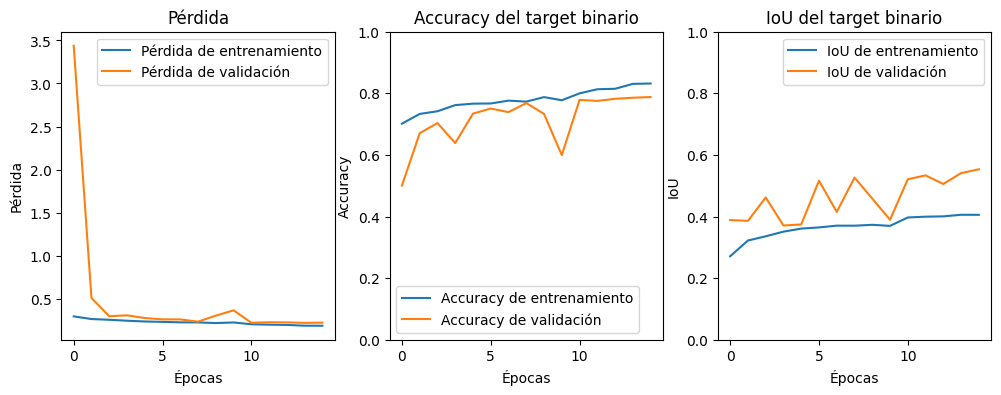

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_4.csv')
plot_learning_curves(history_df_csv,2)

#### Up sample + decoder + residual

In [ ]:
def create_res_up_leaky_relu():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, no utilizada en el modelo

    # Encoder con bloques residuales
    conv0 = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_im)
    conv0 = BatchNormalization()(conv0)
    conv0 = LeakyReLU(alpha=0.1)(conv0)

    conv1 = Conv2D(32, (3, 3), padding='same', use_bias=False)(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block_leaky(pool1, 32)

    conv2 = Conv2D(64, (3, 3), padding='same', use_bias=False)(res1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block_leaky(pool2, 64)

    conv3 = Conv2D(128, (3, 3), padding='same', use_bias=False)(res2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block_leaky(pool3, 128)

    conv4 = Conv2D(256, (3, 3), padding='same', use_bias=False)(res3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block_leaky(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(drop5)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(alpha=0.1)(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block_leaky(merge6, 512)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res6)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(alpha=0.1)(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block_leaky(merge7, 256)

    last_layer = Conv2D(1, (1, 1), activation='sigmoid')(res7)
    # Salida para la máscara
    mask_output = UpSampling2D(4, name ="mask_output")(last_layer)


    # No se utilizará la entrada de variables adicionales para el objetivo binario
    # Simplemente se creará una salida para la máscara.

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(last_layer)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model

# Crear el modelo con Leaky ReLU y sin bias
model = create_res_up_leaky_relu()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 224, 224, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 224, 224, 32)   │            128 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 224, 224, 32)   │          9,216 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 224, 224, 32)   │            128 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 112, 112, 32)   │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 112, 112, 32)   │            128 │ max_pooling2d_13[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 112, 112, 32)   │          9,216 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 112, 112, 32)   │            128 │ conv2d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 112, 112, 32)   │          9,216 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 112, 112, 32)   │            128 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
│                           │                        │                │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyR

 Total params: 11,027,874 (42.07 MB)

 Trainable params: 11,018,082 (42.03 MB)

 Non-trainable params: 9,792 (38.25 KB)

In [ ]:
epochs = 15
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_10_up_res.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_10_up_res.csv', index=False)

Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 161s 394ms/step - loss: 0.3635 - mask_output_binary_io_u_3: 0.3159 - target_output_accuracy: 0.5539 - target_output_auroc: 0.6025 - target_output_precision_3: 0.5378 - target_output_recall_3: 0.7619 - val_loss: 0.4269 - val_mask_output_binary_io_u_3: 0.3223 - val_target_output_accuracy: 0.5040 - val_target_output_auroc: 0.6503 - val_target_output_precision_3: 0.5022 - val_target_output_recall_3: 0.9938 - learning_rate: 0.0010
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 134s 402ms/step - loss: 0.2977 - mask_output_binary_io_u_3: 0.4107 - target_output_accuracy: 0.6918 - target_output_auroc: 0.7668 - target_output_precision_3: 0.6489 - target_output_recall_3: 0.8211 - val_loss: 0.3068 - val_mask_output_binary_io_u_3: 0.4764 - val_target_output_accuracy: 0.7034 - val_target_output_auroc: 0.7557 - val_target_output_precision_3: 0.7539 - val_target_output_recall_3: 0.6060 - learning_rate: 0.0010
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 117s 411ms/step - lo

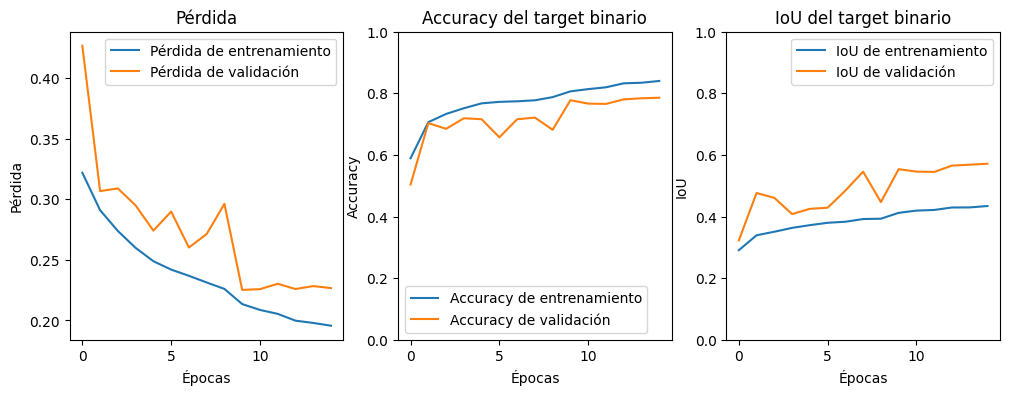

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_10_up_res.csv')
plot_learning_curves(history_df_csv,2)

#### Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
1  0.223868  0.783015   0.763877  0.819556  0.862242  0.565588   
2  0.222578  0.787906   0.771236  0.817291  0.864067  0.553227   
3  0.226697  0.785682   0.791439  0.774510  0.867076  0.571460   

                   Model  
0   history_0_unet_2.csv  
1   history_0_unet_3.csv  
2   history_0_unet_4.csv  
3  history_10_up_res.csv  
history_0_unet_2.csv


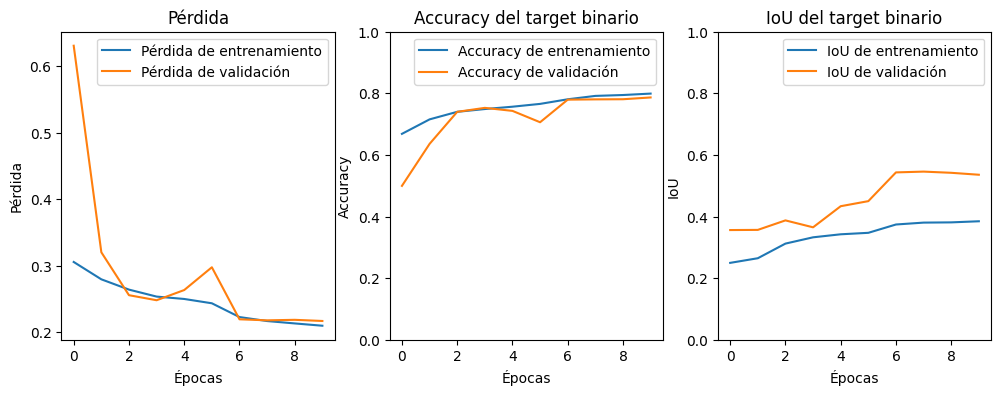

history_0_unet_3.csv


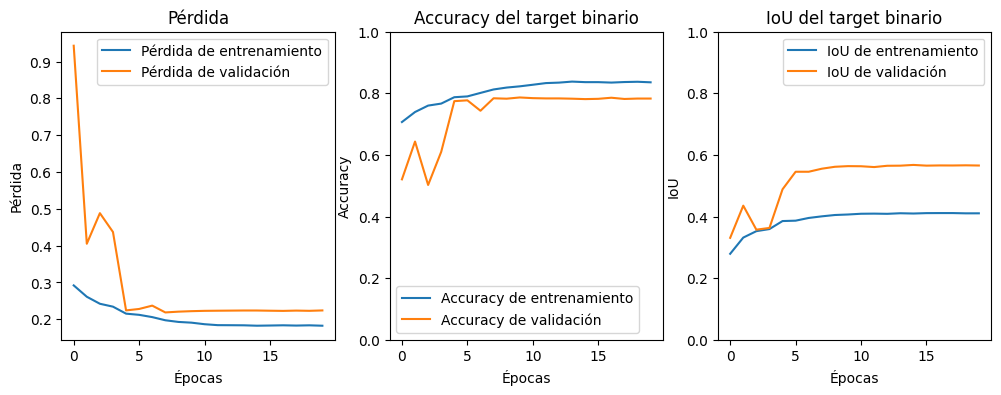

history_0_unet_4.csv


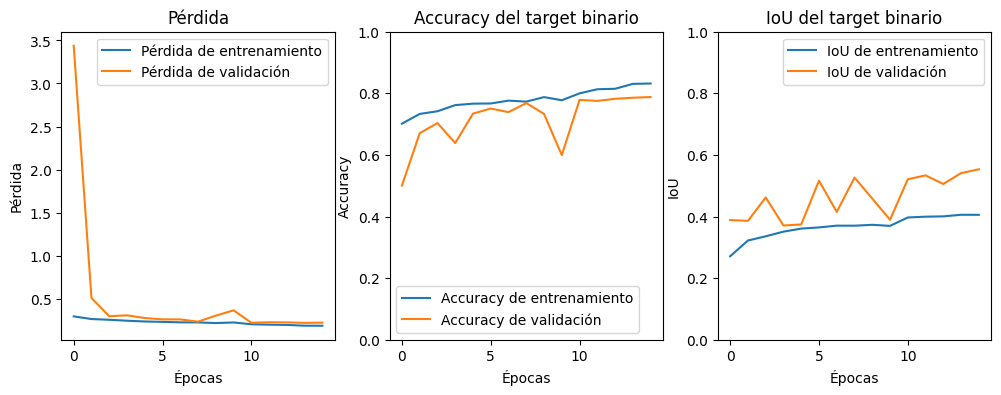

history_10_up_res.csv


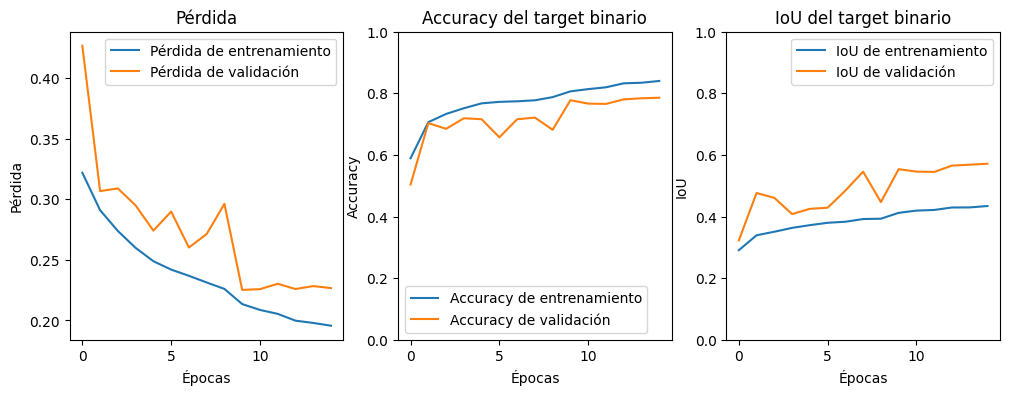

In [ ]:
#profundidad?
lista_history_files =[
                      'history_0_unet_2.csv',  # unet sin var num {'mask_output': 0.7, 'target_output': 0.3}
                      'history_0_unet_3.csv',
                      'history_0_unet_4.csv', # res unet Leaky RELU y
                      'history_10_up_res.csv' # up sample +decoder, resid block + leaky
]
unet_comparar_modelos(lista_history_files)

### Integración de Variables **Numéricas**

#### U-Net

In [ ]:
model = create_unet_2()

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_2.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_2.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2015s 6s/step - loss: 0.3327 - mask_output_binary_io_u: 0.3061 - target_output_accuracy: 0.6221 - target_output_auroc: 0.6708 - target_output_precision: 0.6271 - target_output_recall: 0.6038 - val_loss: 0.6308 - val_mask_output_binary_io_u: 0.3561 - val_target_output_accuracy: 0.4996 - val_target_output_auroc: 0.7298 - val_target_output_precision: 0.0000e+00 - val_target_output_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 214s 693ms/step - loss: 0.2889 - mask_output_binary_io_u: 0.3130 - target_output_accuracy: 0.7112 - target_output_auroc: 0.7740 - target_output_precision: 0.7195 - target_output_recall: 0.7017 - val_loss: 0.3203 - val_mask_output_binary_io_u: 0.3566 - val_target_output_accuracy: 0.6358 - val_target_output_auroc: 0.6999 - val_target_output_precision: 0.6301 - val_target_output_recall: 0.6619 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 197s 691ms/step - loss: 0.2702 - mask_

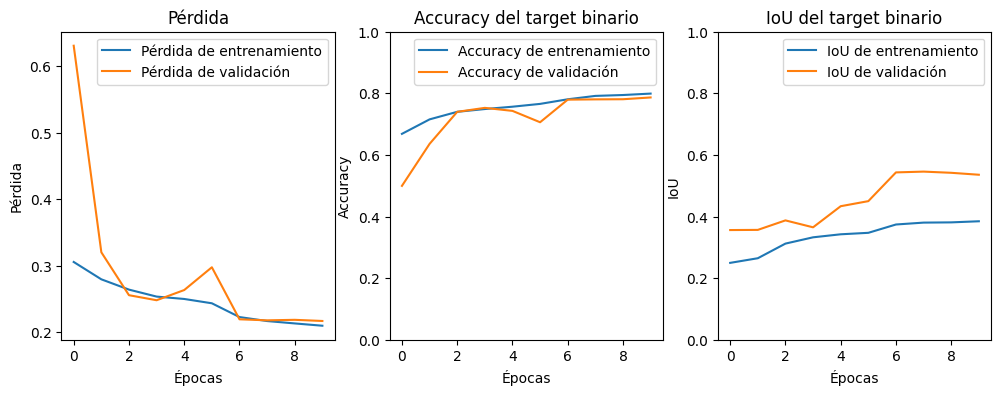

In [ ]:
#con balanceo
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_2.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-VarTarget

In [ ]:
def create_unet_rama_var_num():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de 3 variables adicionales

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6  = Conv2DTranspose(256, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name ="mask_output")(conv9)

    # Procesar las variables adicionales
    var_dense = Dense(16, activation='relu')(var_input)  # Procesar var_input
    var_dense = Dense(32, activation='relu')(var_dense)  # Más capas si es necesario

    # Fusionar la salida de la segmentación con las variables adicionales
    flatten = GlobalAveragePooling2D()(conv9)
    combined = concatenate([flatten, var_dense])  # Concatenar la salida de la máscara y las variables
    dense = Dense(64, activation='relu')(combined)  # Capa densa para procesar la fusión
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_rama_var_num()
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_184 (Conv2D)       │ (None, 224, 224, 32)   │            896 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 224, 224, 32)   │            128 │ conv2d_184[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_185 (Conv2D)       │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 224, 224, 32)   │            128 │ conv2d_185[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (None, 112, 112, 32)   │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_186 (Conv2D)       │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_42[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 112, 112, 64)   │            256 │ conv2d_186[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_187 (Conv2D)       │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 112, 112, 64)   │            256 │ conv2d_187[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_43          │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_43[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 56, 56, 128)    │            512 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 56, 56, 128)    │            512 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,803,490 (29.77 MB)

 Trainable params: 7,800,546 (29.76 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_7.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_7.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 215s 668ms/step - loss: 0.3308 - mask_output_binary_io_u_2: 0.3022 - target_output_accuracy: 0.6822 - target_output_auroc: 0.6998 - target_output_precision_2: 0.6701 - target_output_recall_2: 0.6845 - val_loss: 0.3155 - val_mask_output_binary_io_u_2: 0.3561 - val_target_output_accuracy: 0.6585 - val_target_output_auroc: 0.7642 - val_target_output_precision_2: 0.6042 - val_target_output_recall_2: 0.9208 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 198s 658ms/step - loss: 0.2802 - mask_output_binary_io_u_2: 0.3126 - target_output_accuracy: 0.7174 - target_output_auroc: 0.7805 - target_output_precision_2: 0.7167 - target_output_recall_2: 0.7252 - val_loss: 0.3154 - val_mask_output_binary_io_u_2: 0.3566 - val_target_output_accuracy: 0.7114 - val_target_output_auroc: 0.7565 - val_target_output_precision_2: 0.7019 - val_target_output_recall_2: 0.7374 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 191s 669ms/step - lo

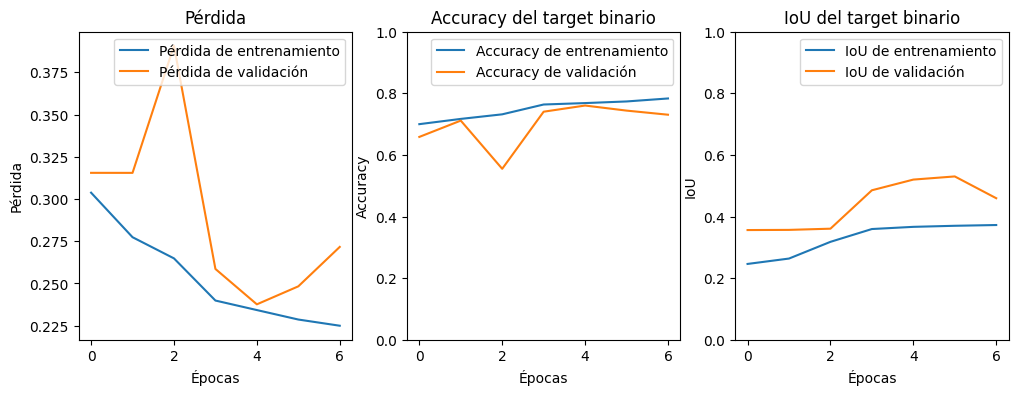

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_7.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-VarFull

In [ ]:
def create_unet_rama_var_num_v2():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de 3 variables adicionales

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6  = Conv2DTranspose(256, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Procesar las variables adicionales
    var_dense = Dense(512, activation='relu')(var_input)  # Capa densa para las variables adicionales
    var_dense = BatchNormalization(momentum=0.9)(var_dense)

    # Ajustar la forma de var_dense para que sea (1, 1, 512)
    var_reshaped = Reshape((1, 1, 512))(var_dense)
    var_reshaped = UpSampling2D(size=(image_size // 1, image_size // 1))(var_reshaped)  # Ajustar a 224x224

    # Fusionar con la salida de la U-Net
    merged_output = concatenate([conv9, var_reshaped], axis=-1)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(merged_output)

    # Salida para el objetivo binario
    flatten = GlobalAveragePooling2D()(merged_output)
    dense = Dense(64, activation='relu')(flatten)  # Capa densa para procesar la fusión
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_rama_var_num_v2()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 56, 56, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 7,803,490 (29.77 MB)

 Trainable params: 7,800,546 (29.76 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_8.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_8.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 264s 685ms/step - loss: 0.3414 - mask_output_binary_io_u: 0.2988 - target_output_accuracy: 0.6807 - target_output_auroc: 0.6916 - target_output_precision: 0.6624 - target_output_recall: 0.7413 - val_loss: 0.2797 - val_mask_output_binary_io_u: 0.4234 - val_target_output_accuracy: 0.7003 - val_target_output_auroc: 0.7799 - val_target_output_precision: 0.7420 - val_target_output_recall: 0.6148 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 202s 650ms/step - loss: 0.2850 - mask_output_binary_io_u: 0.3564 - target_output_accuracy: 0.7102 - target_output_auroc: 0.7688 - target_output_precision: 0.7077 - target_output_recall: 0.7201 - val_loss: 0.2744 - val_mask_output_binary_io_u: 0.4299 - val_target_output_accuracy: 0.7137 - val_target_output_auroc: 0.7972 - val_target_output_precision: 0.7028 - val_target_output_recall: 0.7427 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 184s 645ms/step - loss: 0.2769 - mask_output

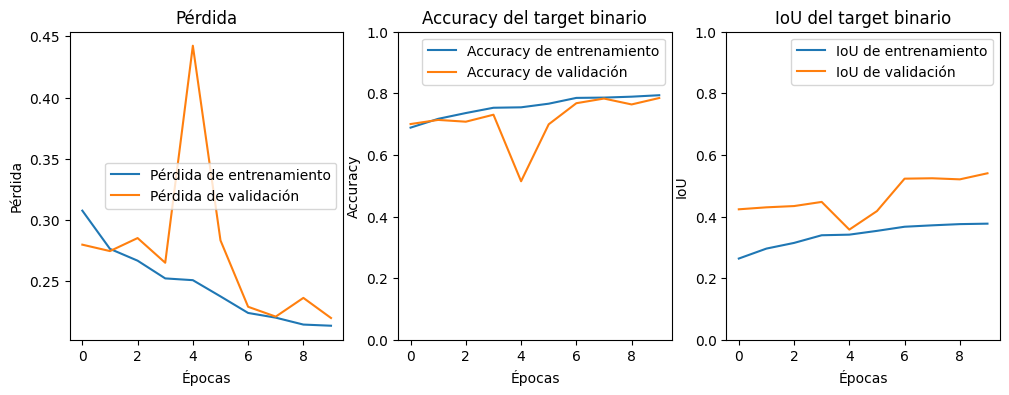

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_8.csv')
plot_learning_curves(history_df_csv,2)

#### U-Net-VarSplit

Separa el procesamiento de las variables adicionales en dos ramas: una para la máscara y otra para el objetivo binario. Cada rama tiene su propia capa densa (con 64 neuronas) y procesamiento posterior.

In [ ]:
def create_unet_rama_var_num_v3():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de 3 variables adicionales

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6  = Conv2DTranspose(256, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu', strides=2)(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Procesar las variables adicionales para la máscara
    var_dense_mask = Dense(64, activation='relu')(var_input)  # Capa densa para las variables adicionales
    var_dense_mask = BatchNormalization(momentum=0.9)(var_dense_mask)

    # Ajustar la forma para la máscara
    var_reshaped_mask = Dense(512, activation='relu')(var_dense_mask)
    var_reshaped_mask = Reshape((1, 1, 512))(var_reshaped_mask)
    var_reshaped_mask = UpSampling2D(size=(image_size // 1, image_size // 1))(var_reshaped_mask)

    # Fusionar con la salida de la U-Net para la máscara
    merged_mask_output = concatenate([conv9, var_reshaped_mask], axis=-1)
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(merged_mask_output)

    # Procesar las variables adicionales para el objetivo binario
    var_dense_target = Dense(64, activation='relu')(var_input)  # Capa densa para el objetivo binario
    var_dense_target = BatchNormalization(momentum=0.9)(var_dense_target)

    # Conectar para el objetivo binario
    flatten = GlobalAveragePooling2D()(conv9)
    combined_flatten = concatenate([flatten, var_dense_target])
    dense_target = Dense(64, activation='relu')(combined_flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense_target)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_rama_var_num_v3()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 224, 224, 32)   │            128 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 224, 224, 32)   │            128 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 112, 112, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 112, 112, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 56, 56, 128)    │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 56, 56, 128)    │            512 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,805,026 (29.77 MB)

 Trainable params: 7,802,850 (29.77 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_9.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_9.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 195s 588ms/step - loss: 0.3342 - mask_output_binary_io_u_1: 0.3072 - target_output_accuracy: 0.6901 - target_output_auroc: 0.7059 - target_output_precision_1: 0.6773 - target_output_recall_1: 0.7201 - val_loss: 0.3842 - val_mask_output_binary_io_u_1: 0.3561 - val_target_output_accuracy: 0.6518 - val_target_output_auroc: 0.7159 - val_target_output_precision_1: 0.7002 - val_target_output_recall_1: 0.5321 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 175s 577ms/step - loss: 0.2849 - mask_output_binary_io_u_1: 0.3306 - target_output_accuracy: 0.7147 - target_output_auroc: 0.7518 - target_output_precision_1: 0.7008 - target_output_recall_1: 0.7527 - val_loss: 0.3027 - val_mask_output_binary_io_u_1: 0.4139 - val_target_output_accuracy: 0.6736 - val_target_output_auroc: 0.7858 - val_target_output_precision_1: 0.6257 - val_target_output_recall_1: 0.8678 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 168s 590ms/step - lo

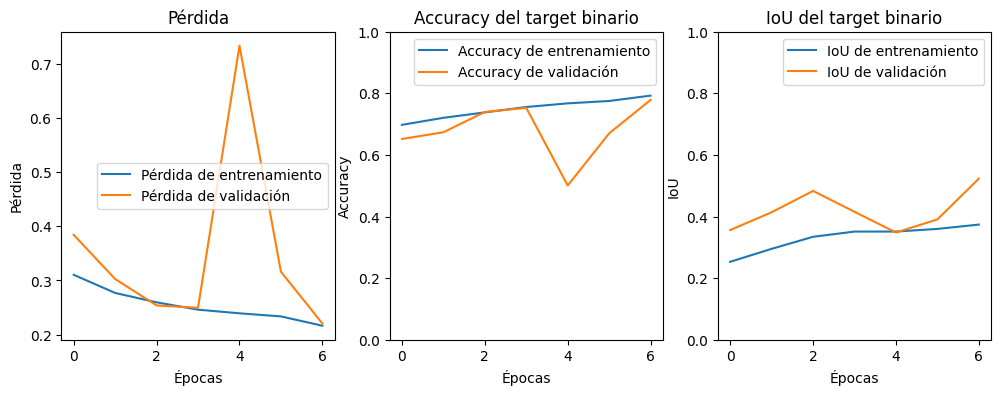

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_9.csv')
plot_learning_curves(history_df_csv,2)

#### Comparacion

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
1  0.271598  0.730547   0.722944  0.744871  0.804352  0.459441   
2  0.219700  0.784793   0.778646  0.796625  0.865136  0.540384   
3  0.220614  0.778568   0.770165  0.792150  0.862495  0.522992   

                  Model  
0  history_0_unet_2.csv  
1  history_0_unet_7.csv  
2  history_0_unet_8.csv  
3  history_0_unet_9.csv  
history_0_unet_2.csv


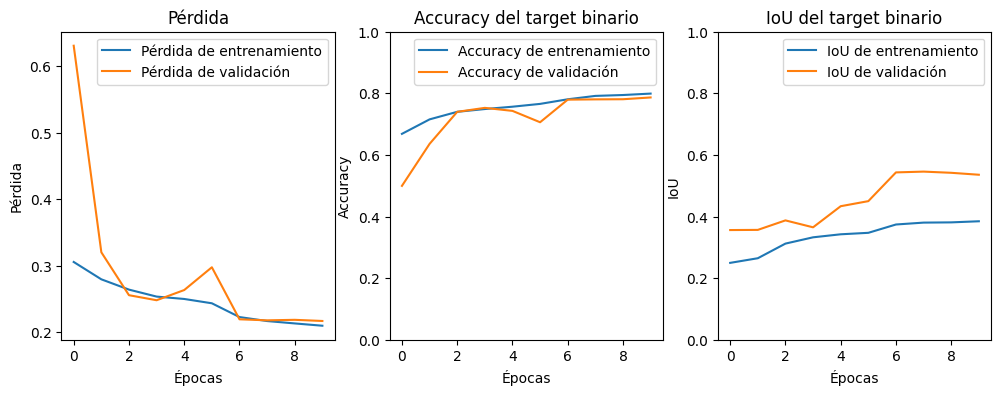

history_0_unet_7.csv


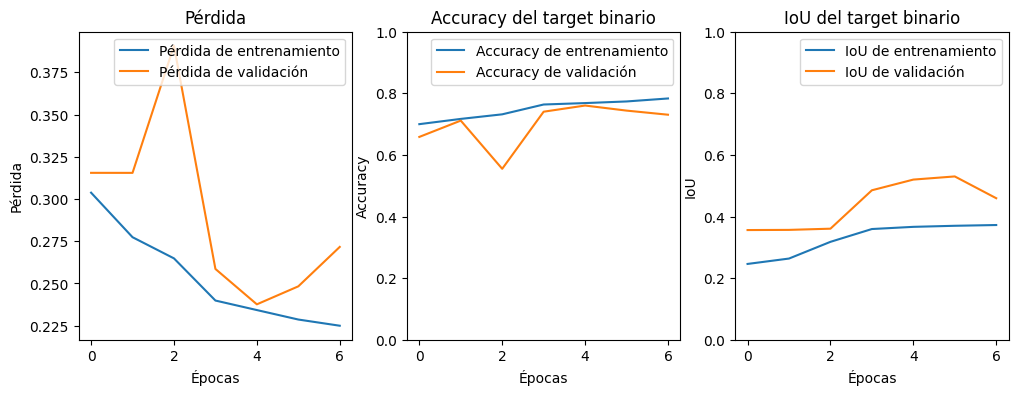

history_0_unet_8.csv


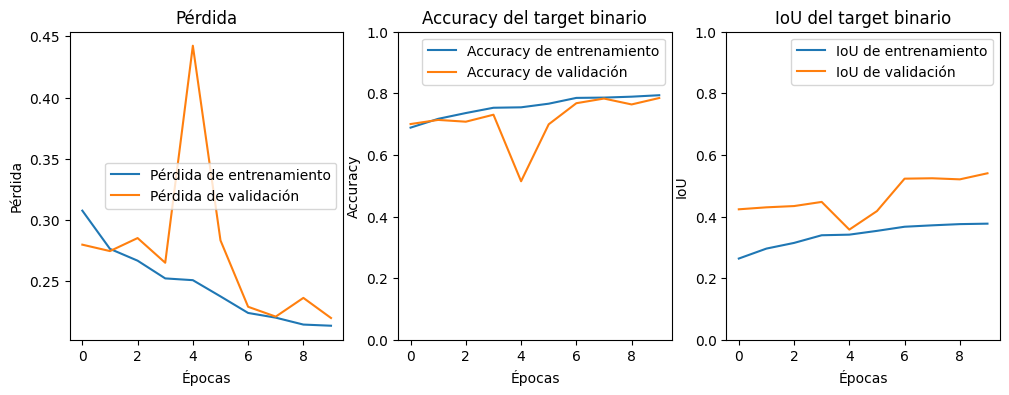

history_0_unet_9.csv


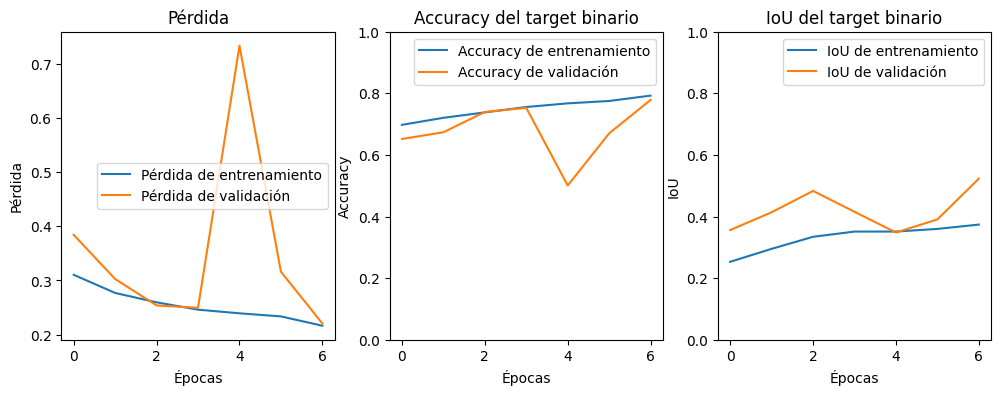

In [ ]:
#var addicionales?
lista_history_files =[
                      'history_0_unet_2.csv',  # U-Net
                      'history_0_unet_7.csv', # U-Net-VarTarget
                      'history_0_unet_8.csv', # U-Net-VarFull
                      'history_0_unet_9.csv' # U-Net-VarSplit


]
unet_comparar_modelos(lista_history_files)

EVALUAR EL MODELO. GRAD CAM

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Asumimos que ya tienes un modelo entrenado
model = model  # tu modelo ya entrenado
last_conv_layer_name = "conv2d_22"  # Cambia esto según el nombre de tu capa convolucional

# Preprocesar la imagen de entrada
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(512, 512))  # Tamaño de imagen que usaste
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Función Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Crear un modelo que mapea la entrada a la activación de la última capa convolucional
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Calcular los gradientes de la clase predicha respecto a la salida de la última capa convolucional
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calcula los gradientes de la clase objetivo respecto a la activación de la última capa convolucional
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Gradientes medios de cada filtro (canal)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar las activaciones de la última capa convolucional por la importancia de los gradientes
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizar el heatmap entre 0 y 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Superponer el heatmap sobre la imagen original
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Aplicar un mapa de colores al heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superponer el heatmap sobre la imagen original
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Ruta a tu imagen
image_path = 'ruta/a/tu/imagen.png'
preprocessed_image = preprocess_image(image_path)

# Generar el heatmap
heatmap = make_gradcam_heatmap(preprocessed_image, model, last_conv_layer_name)

# Superponer el heatmap en la imagen original
superimposed_img = superimpose_heatmap(image_path, heatmap)

# Mostrar el resultado
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### Unet con transfer learning

#### Unet + VGG16 menos filtros

El uso de Conv2DTranspose en lugar de UpSampling2D

https://neurohive.io/en/popular-networks/vgg16/

In [ ]:
def create_unet_with_VGG16():
    inputs = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales

    # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio
    augmented = RandomContrast(0.1)(augmented)  # Contraste aleatorio
    augmented = RandomBrightness(0.1)(augmented)  # Brillo aleatorio

    # Cargar el modelo base preentrenado
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=augmented)

    # Congelar las capas del modelo base
    for layer in base_model.layers:
        layer.trainable = False

    # Usar las capas del modelo base como el encoder
    conv1 = base_model.get_layer('block1_conv2').output
    pool1 = base_model.get_layer('block1_pool').output

    conv2 = base_model.get_layer('block2_conv2').output
    pool2 = base_model.get_layer('block2_pool').output

    conv3 = base_model.get_layer('block3_conv3').output
    drop3 = Dropout(0.5)(conv3)
    pool3 = base_model.get_layer('block3_pool').output

    conv4 = base_model.get_layer('block4_conv3').output
    drop4 = Dropout(0.5)(conv4)
    pool4 = base_model.get_layer('block4_pool').output

    conv5 = base_model.get_layer('block5_conv3').output  # Último bloque

    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(bottleneck)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(conv9)

    # No se utilizará la entrada de variables adicionales para el objetivo binario
    # Simplemente se creará una salida para la máscara.

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(conv9)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])

    return model

# Ejemplo de creación del modelo
model = create_unet_with_VGG16()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_1         │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_1             │ (None, 224, 224, 3)    │              0 │ random_rotation_1[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_contrast_1         │ (None, 224, 224, 3)    │              0 │ random_zoom_1[0][0]    │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_brightness_1       │ (None, 224, 224, 3)    │              0 │ random_contrast_1[0][… │
│ (RandomBrightness)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ random_brightness_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)

 Total params: 10,756,258 (41.03 MB)

 Trainable params: 3,120,994 (11.91 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_4_unet_with_VGG16_1.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_4_unet_with_VGG16_1.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2455s 8s/step - loss: 1.0335 - mask_output_binary_io_u_1: 0.4682 - target_output_accuracy: 0.5002 - target_output_auroc: 0.5072 - target_output_precision_1: 0.5006 - target_output_recall_1: 0.3470 - val_loss: 0.8388 - val_mask_output_binary_io_u_1: 0.4703 - val_target_output_accuracy: 0.5665 - val_target_output_auroc: 0.7983 - val_target_output_precision_1: 0.8725 - val_target_output_recall_1: 0.1566 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 128s 444ms/step - loss: 0.8626 - mask_output_binary_io_u_1: 0.4702 - target_output_accuracy: 0.5689 - target_output_auroc: 0.6156 - target_output_precision_1: 0.5928 - target_output_recall_1: 0.4537 - val_loss: 0.7721 - val_mask_output_binary_io_u_1: 0.4830 - val_target_output_accuracy: 0.7577 - val_target_output_auroc: 0.8304 - val_target_output_precision_1: 0.7143 - val_target_output_recall_1: 0.8607 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 132s 463ms/step - loss

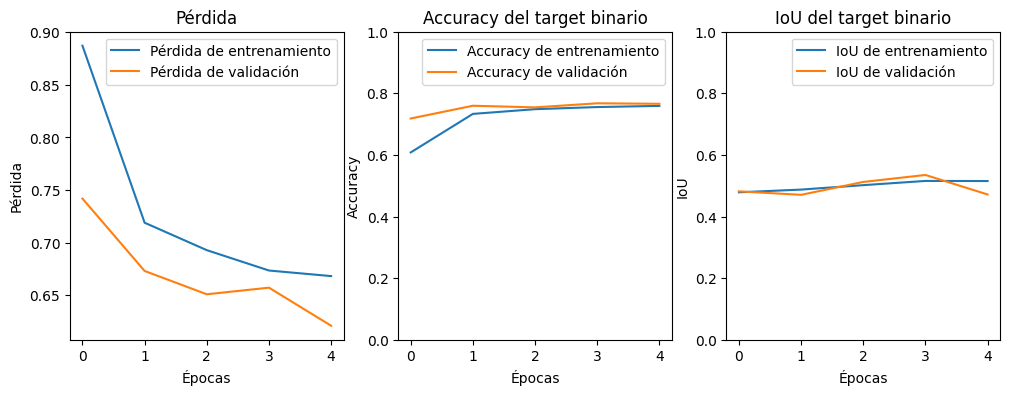

In [ ]:
# augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
#  augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_4_unet_with_VGG16.csv')
plot_learning_curves(history_df_csv,2)

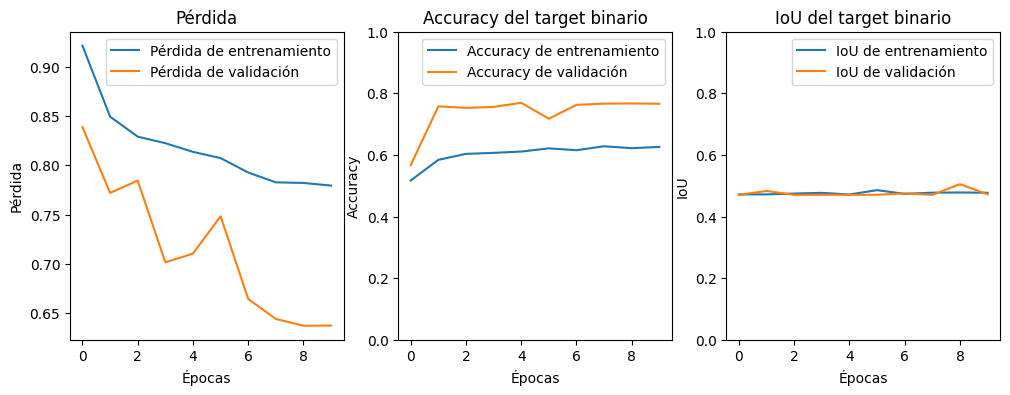

In [ ]:
#    augmented = RandomRotation(0.1)(inputs)  # Rotación aleatoria
#    augmented = RandomZoom(0.1)(augmented)   # Zoom aleatorio
#    augmented = RandomContrast(0.1)(augmented)  # Contraste aleatorio
#    augmented = RandomBrightness(0.1)(augmented)  # Brillo aleatorio

history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_4_unet_with_VGG16_1.csv')
plot_learning_curves(history_df_csv,2)

#### Unet + Mobilnet

In [ ]:
def create_unet_with_mobilenet():
    # Definición de la entrada del modelo
    inputs = Input(shape=(224, 224, 3), name="input_image")
    var_input = Input(shape=(3,))  # Entrada de variables adicionales

        # Aplicar data augmentation
    augmented = RandomRotation(0.2)(inputs)  # Rotación aleatoria
    augmented = RandomZoom(0.2)(augmented)   # Zoom aleatorio
    augmented = RandomContrast(0.1)(augmented)  # Contraste aleatorio
    augmented = RandomBrightness(0.1)(augmented)  # Brillo aleatorio

    # Inicialización de MobileNetV2 como encoder
    encoder = MobileNetV2(input_tensor=augmented, weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Congelar las capas del encoder
    for layer in encoder.layers:
        layer.trainable = False

    # Extraer las salidas de las capas del encoder
    conv1 = encoder.get_layer("input_image").output  # Primera capa
    conv2 = encoder.get_layer("block_1_expand_relu").output  # Primera capa
    conv3 = encoder.get_layer("block_3_expand_relu").output  # Segunda capa
    conv4 = encoder.get_layer("block_6_expand_relu").output  # Tercera capa
    encoder_output = encoder.get_layer("block_13_expand_relu").output  # Salida final del encoder

    x = encoder_output

    # Primera etapa de decodificación
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, conv4], axis=3)  # Concatenar con conv4 usando concatenate
    x = Conv2D(64, (3, 3), padding="same")(x)  # 64 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same")(x)  # 64 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Segunda etapa de decodificación
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, conv3], axis=3)  # Concatenar con conv3 usando concatenate
    x = Conv2D(48, (3, 3), padding="same")(x)  # 48 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(48, (3, 3), padding="same")(x)  # 48 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Tercera etapa de decodificación
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, conv2], axis=3)  # Concatenar con conv2 usando concatenate
    x = Conv2D(32, (3, 3), padding="same")(x)  # 32 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, (3, 3), padding="same")(x)  # 32 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Cuarta etapa de decodificación
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, conv1], axis=3)  # Concatenar con conv1 usando concatenate
    x = Conv2D(16, (3, 3), padding="same")(x)  # 16 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, (3, 3), padding="same")(x)  # 16 filtros
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Capa de salida
    x = Conv2D(1, (1, 1), padding="same")(x)  # Capa de salida con 1 filtro
    mask_output = Activation("sigmoid", name="mask_output")(x)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(x)
    dense = Dense(64, activation='relu')(flatten)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Creación del modelo
    model = Model(inputs=[inputs, var_input], outputs=[mask_output, target_output])
    return model

# Ejemplo de creación del modelo
model = create_unet_with_mobilenet()
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_6         │ (None, 224, 224, 3)    │              0 │ input_image[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_6             │ (None, 224, 224, 3)    │              0 │ random_rotation_6[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_contrast_6         │ (None, 224, 224, 3)    │              0 │ random_zoom_6[0][0]    │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_brightness_6       │ (None, 224, 224, 3)    │              0 │ random_contrast_6[0][… │
│ (RandomBrightness)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ random_brightness_6[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN    

 Total params: 1,265,922 (4.83 MB)

 Trainable params: 649,026 (2.48 MB)

 Non-trainable params: 616,896 (2.35 MB)

In [ ]:
epochs = 10
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_9_unet_with_MobilNet.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_9_with_MobilNet.csv', index=False)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 351ms/step - loss: 1.0198 - mask_output_binary_io_u_3: 0.4628 - target_output_accuracy: 0.4922 - target_output_auroc: 0.4850 - target_output_precision_3: 0.4867 - target_output_recall_3: 0.3925 - val_loss: 0.8767 - val_mask_output_binary_io_u_3: 0.4703 - val_target_output_accuracy: 0.5004 - val_target_output_auroc: 0.5000 - val_target_output_precision_3: 0.5004 - val_target_output_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 97s 337ms/step - loss: 0.8796 - mask_output_binary_io_u_3: 0.4722 - target_output_accuracy: 0.4979 - target_output_auroc: 0.4875 - target_output_precision_3: 0.4945 - target_output_recall_3: 0.4335 - val_loss: 0.8605 - val_mask_output_binary_io_u_3: 0.4701 - val_target_output_accuracy: 0.5011 - val_target_output_auroc: 0.5421 - val_target_output_precision_3: 0.5011 - val_target_output_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 106s 372ms/step - los

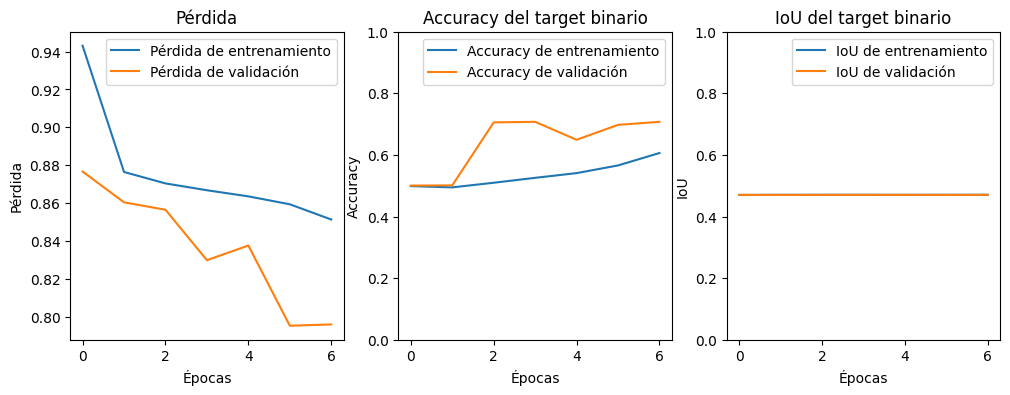

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_9_with_MobilNet.csv')
plot_learning_curves(history_df_csv,2)

#### Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.217045  0.786572   0.766063  0.825933  0.868043  0.535646   
1  0.620935  0.766014   0.730173  0.845829  0.851912  0.471573   
2  0.637408  0.766118   0.720913  0.869449  0.844967  0.472021   
3  0.796119  0.707426   0.695689  0.734166  0.761189  0.470294   

                             Model  
0             history_0_unet_2.csv  
1    history_4_unet_with_VGG16.csv  
2  history_4_unet_with_VGG16_1.csv  
3      history_9_with_MobilNet.csv  
history_0_unet_2.csv


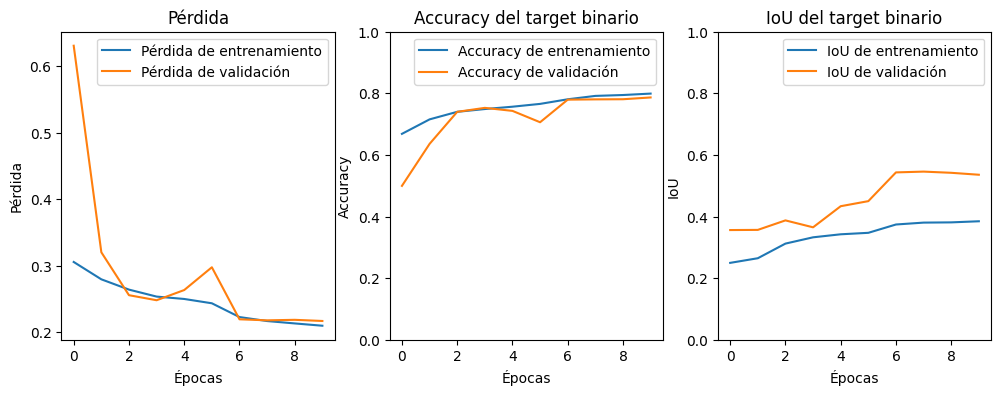

history_4_unet_with_VGG16.csv


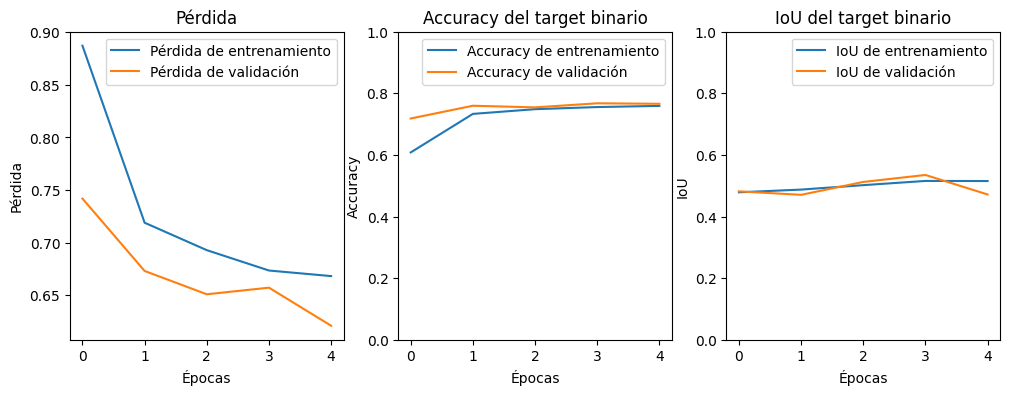

history_4_unet_with_VGG16_1.csv


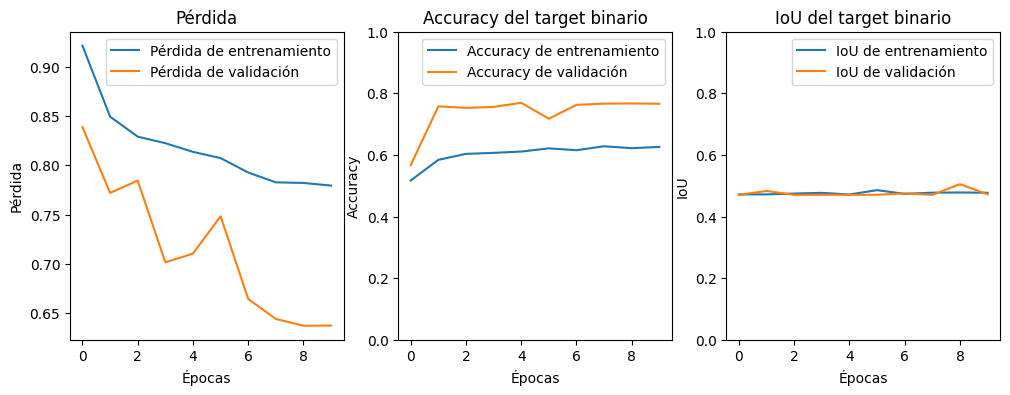

history_9_with_MobilNet.csv


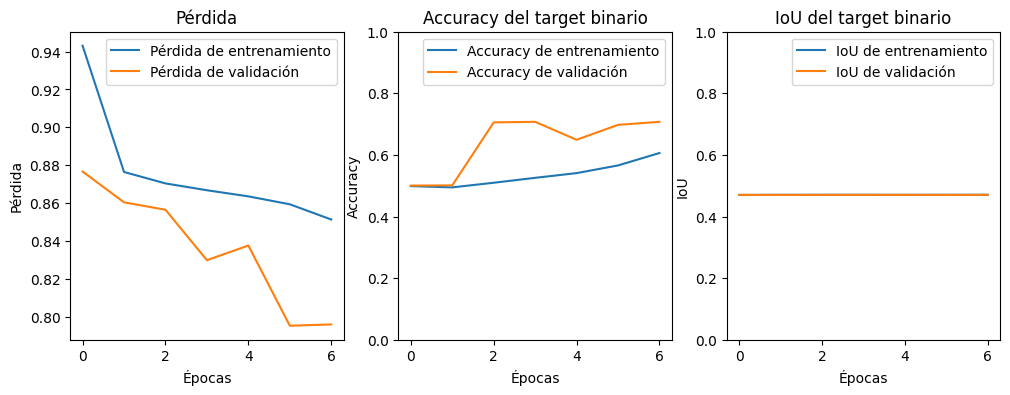

In [ ]:
lista_history_files =[
                      'history_0_unet_2.csv',  #{'mask_output': 0.7, 'target_output': 0.3}
                      'history_4_unet_with_VGG16.csv',
                      'history_4_unet_with_VGG16_1.csv',
                      'history_9_with_MobilNet.csv'

]
unet_comparar_modelos(lista_history_files)

## Modelo Final para Clasificación y Segmentacion


#### U-net-Hybrid

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=main_dir + "model_training/" + 'mejor_modelo_accuracy.keras',  # Ruta para guardar el modelo
    monitor='val_target_output_accuracy',  # Monitorea la precisión de validación
    save_best_only=True,  # Guarda solo el mejor modelo
    mode='max',  # Modo: 'max' porque queremos maximizar la precisión
    verbose=1  # Imprimir mensajes sobre el guardado del modelo
)

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def residual_block_leaky(input, n_filters):
    # Normalización de la entrada
    res = BatchNormalization()(input)
    # Primera convolución sin bias y sin activación
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    # Segunda convolución sin bias y sin activación
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    # Suma de la entrada original con la salida de las capas convolucionales
    res = Add()([res, input])
    # Activación final con Leaky ReLU
    res = LeakyReLU(alpha=0.1)(res)
    return res

In [ ]:
def exper():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))  # Entrada de variables adicionales, no utilizada en el modelo

    # Encoder con bloques residuales
    conv0 = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_im)
    conv0 = BatchNormalization()(conv0)
    conv0 = LeakyReLU(alpha=0.1)(conv0)

    conv1 = Conv2D(32, (3, 3), padding='same', use_bias=False)(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block_leaky(pool1, 32)

    conv2 = Conv2D(64, (3, 3), padding='same', use_bias=False)(res1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block_leaky(pool2, 64)

    conv3 = Conv2D(128, (3, 3), padding='same', use_bias=False)(res2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block_leaky(pool3, 128)

    conv4 = Conv2D(256, (3, 3), padding='same', use_bias=False)(res3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block_leaky(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(drop5)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(alpha=0.1)(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block_leaky(merge6, 512)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res6)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(alpha=0.1)(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block_leaky(merge7, 256)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res7)
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.1)(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    res8 = residual_block_leaky(merge8, 128)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res8)
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=0.1)(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    res9 = residual_block_leaky(merge9, 64)

    # Procesar las variables adicionales
    var_dense = Dense(64, activation='relu')(var_input)  # Capa densa para las variables adicionales
    var_dense = BatchNormalization(momentum=0.9)(var_dense)

    # Ajustar la forma de var_dense para que sea (1, 1, 128)
    var_reshaped = Reshape((1, 1, 64))(var_dense)
    var_reshaped = UpSampling2D(size=(image_size // 1, image_size // 1))(var_reshaped)  # Ajustar a 224x224

    # Fusionar con la salida de la U-Net
    merged_output = concatenate([res9, var_reshaped], axis=-1)

    # Salida para la máscara
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(merged_output)

    # Salida para el target binario
    flatten = GlobalAveragePooling2D()(merged_output)
    dense = Dense(64, use_bias=False)(flatten)
    dense = BatchNormalization()(dense)
    dense = LeakyReLU(alpha=0.1)(dense)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Crear el modelo
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model

# Crear el modelo con Leaky ReLU y sin bias
model = exper()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 224, 224, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,216 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 224, 224, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │          9,216 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │          9,216 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_4… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 112, 112, 32)   │              0 │ add[0][0]              │
├──────────────────────

 Total params: 11,489,826 (43.83 MB)

 Trainable params: 11,478,434 (43.79 MB)

 Non-trainable params: 11,392 (44.50 KB)

Unet {'mask_output': 0.9, 'target_output': 0.1} - mejor

In [ ]:
epochs = 30
steps_per_epoch = len(df_train)//batch_size
validation_steps = len(df_val)//batch_size
learning_rate = 0.001

# Cargar el modelo
#model = tf.keras.models.load_model(main_dir + "model_training/" + 'model_0_unet_clas.keras',
#                                    custom_objects={'BinaryIoU': BinaryIoU})

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.9, 'target_output': 0.1})

# Entrenamiento del modelo
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint_callback,early_stopping,reduce_lr])

# Guardar el modelo entrenado
model.save(main_dir + "model_training/" + 'model_0_unet_12.keras')

# Guardar historial de entrenamiento
history_df = pd.DataFrame(history.history)
history_df.to_csv(main_dir + "model_training/" + 'history_0_unet_12.csv', index=False)

Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2158s 7s/step - loss: 0.2399 - mask_output_binary_io_u: 0.3364 - target_output_accuracy: 0.6896 - target_output_auroc: 0.7288 - target_output_precision: 0.6798 - target_output_recall: 0.7322 - val_loss: 0.2568 - val_mask_output_binary_io_u: 0.4442 - val_target_output_accuracy: 0.7306 - val_target_output_auroc: 0.8094 - val_target_output_precision: 0.7479 - val_target_output_recall: 0.6966 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 280s 901ms/step - loss: 0.1848 - mask_output_binary_io_u: 0.4078 - target_output_accuracy: 0.7196 - target_output_auroc: 0.7807 - target_output_precision: 0.7183 - target_output_recall: 0.7207 - val_loss: 0.3621 - val_mask_output_binary_io_u: 0.3971 - val_target_output_accuracy: 0.5883 - val_target_output_auroc: 0.7759 - val_target_output_precision: 0.5506 - val_target_output_recall: 0.9707 - learning_rate: 0.0010
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 257s 903ms/step - loss: 0.1664 - mask_output_binary_io_u: 0.4546 - target_output_accuracy: 0.7473 - target_output_auroc: 0.8210 - target_output_precision: 0.7470 - target_output_recall: 0.7495 - val_loss: 0.2019 - val_mask_output_binary_io_u: 0.5341 - val_target_output_accuracy: 0.6670 - val_target_output_auroc: 0.8374 - val_target_output_precision: 0.6045 - val_target_output_recall: 0.9752 - learning_rate: 0.0010
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 249s 874ms/step - loss: 0.1593 - mask_output_binary_io_

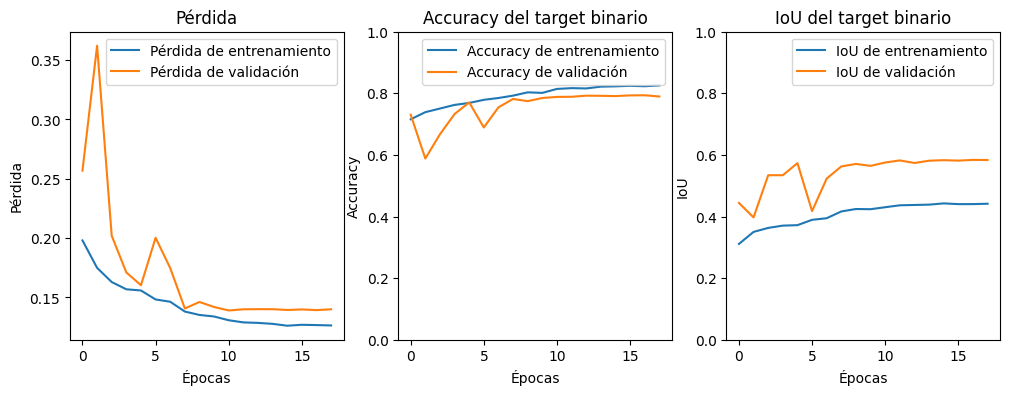

In [ ]:
history_df_csv=pd.read_csv(main_dir + "model_training/" +'history_0_unet_12.csv')
plot_learning_curves(history_df_csv,2)

 Comparar

       Loss  Accuracy  Precision    Recall       AUC       IoU  \
0  0.139294  0.793686   0.789151  0.801778  0.872643  0.583844   

                   Model  
0  history_0_unet_12.csv  
history_0_unet_12.csv


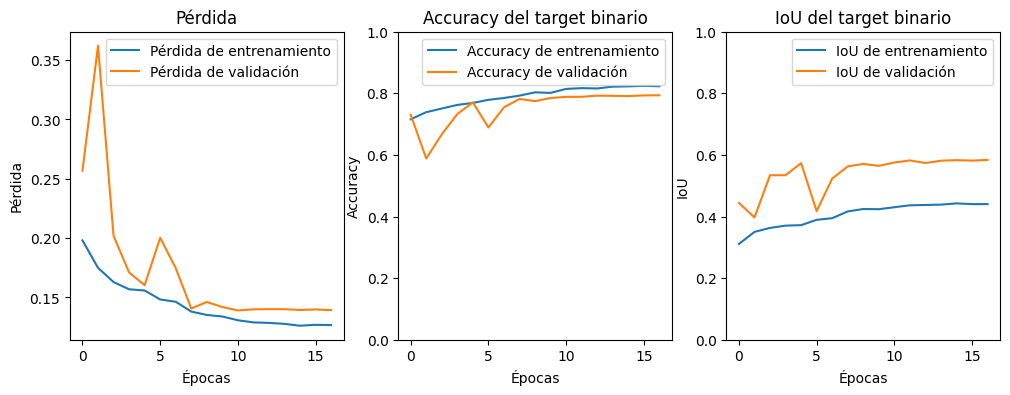

In [ ]:
lista_history_files =[               'history_0_unet_12.csv'


]
unet_comparar_modelos(lista_history_files)

#### Evaluar en Test

In [ ]:
model_dir = main_dir + "model_training/"
model = load_model(model_dir + 'model_0_unet_12.keras' )

In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - loss: 0.1535 - mask_output_binary_io_u: 0.6524 - target_output_accuracy: 0.7898 - target_output_auroc: 0.8471 - target_output_precision: 0.7741 - target_output_recall: 0.8288


[0.1468675136566162,
 0.6513587236404419,
 0.7753743529319763,
 0.854817271232605,
 0.7538461685180664,
 0.8166666626930237]

### Comparación visual de máscaras predichas y reales

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


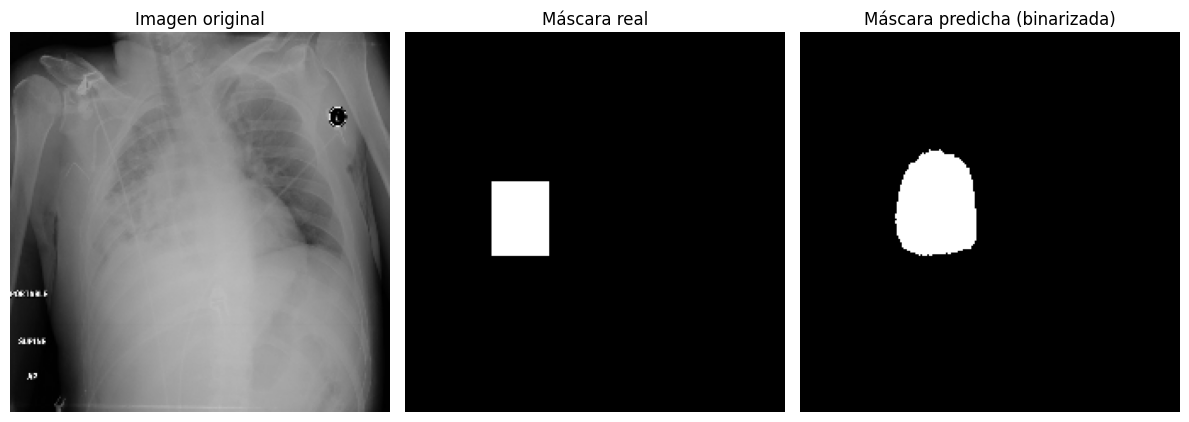

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-35-ac958dd32004>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Target real: {targets[i].numpy()}, Target predicho: {int(pred_target[0] > 0.5)}")


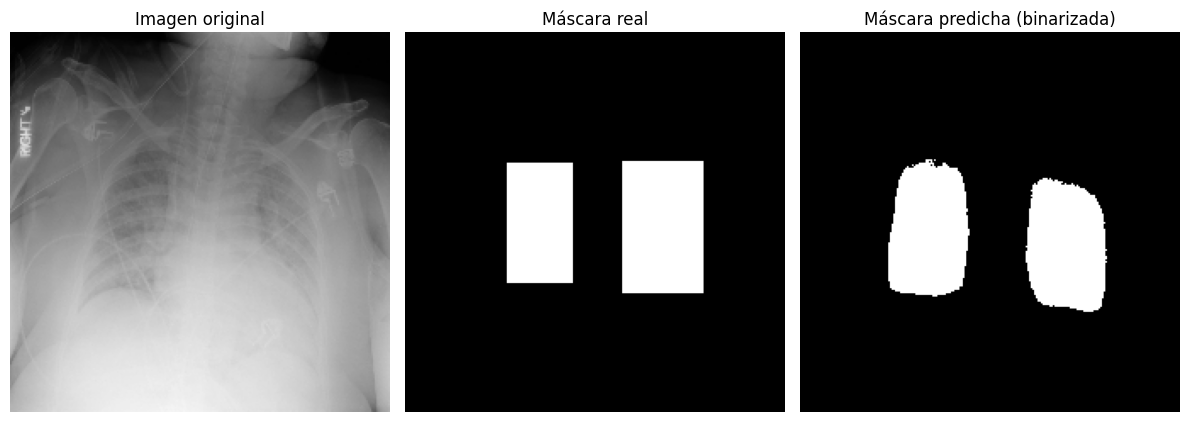

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


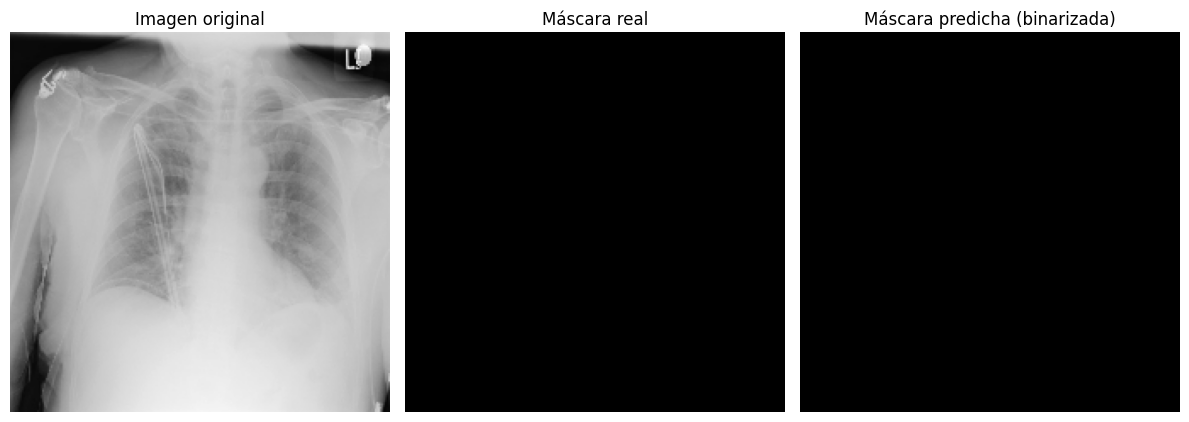

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


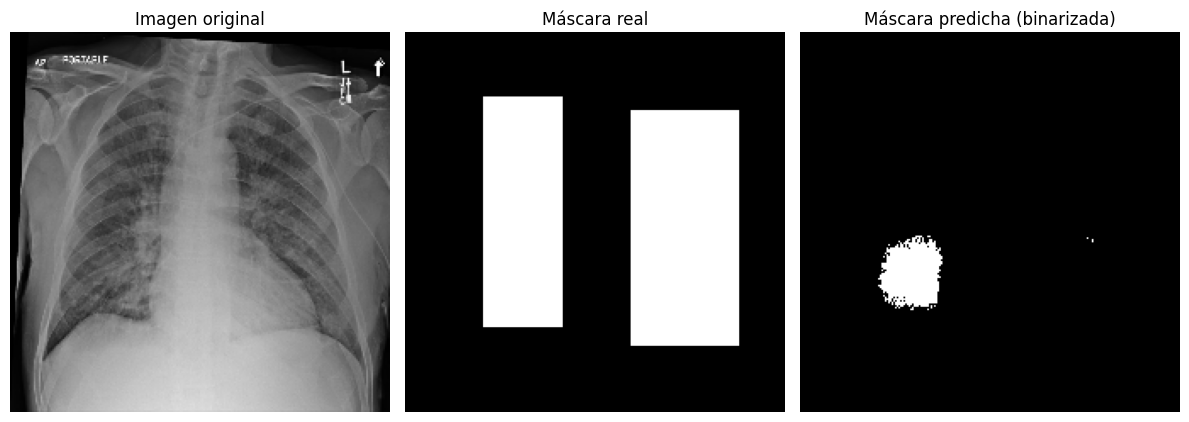

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


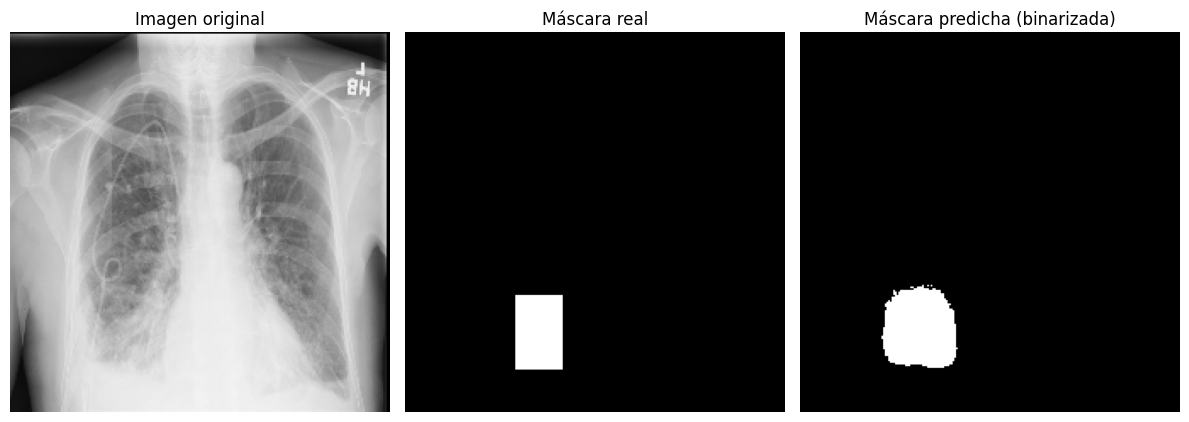

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


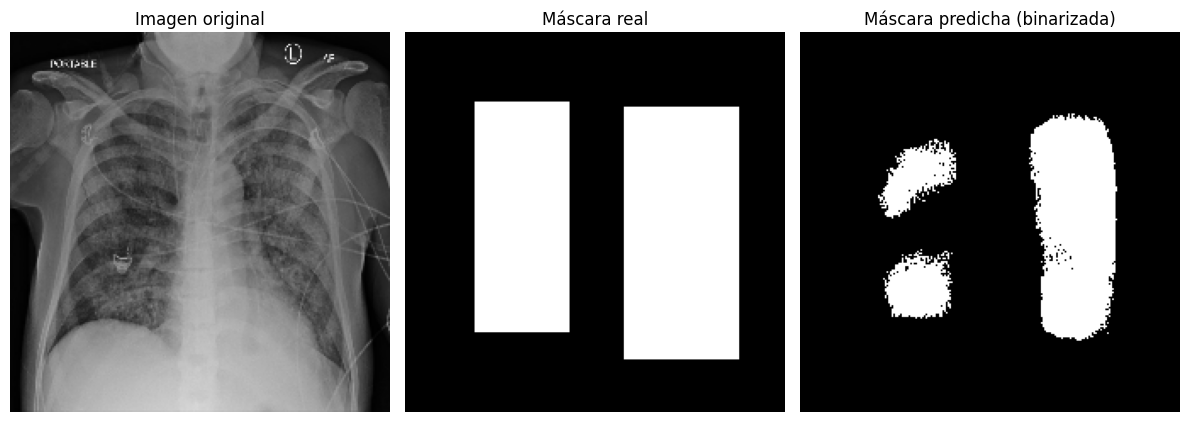

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


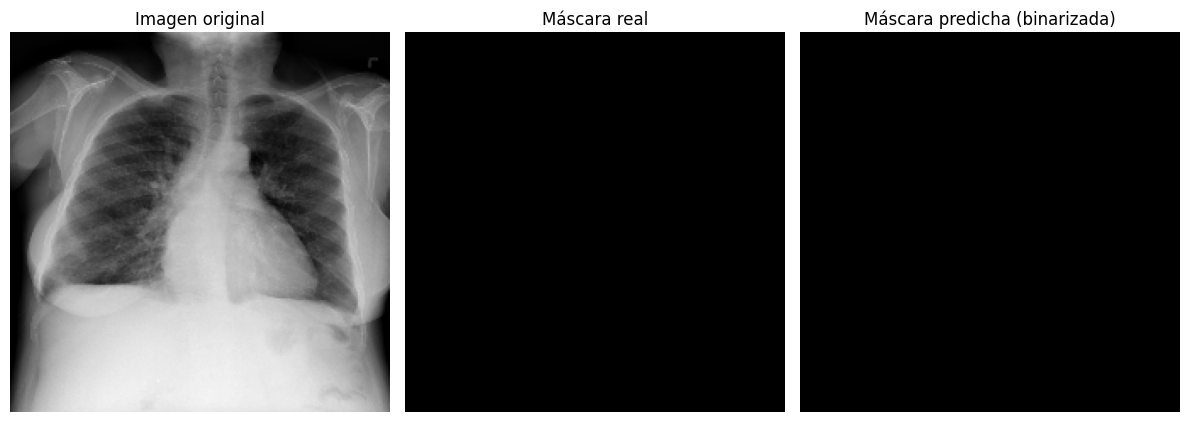

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


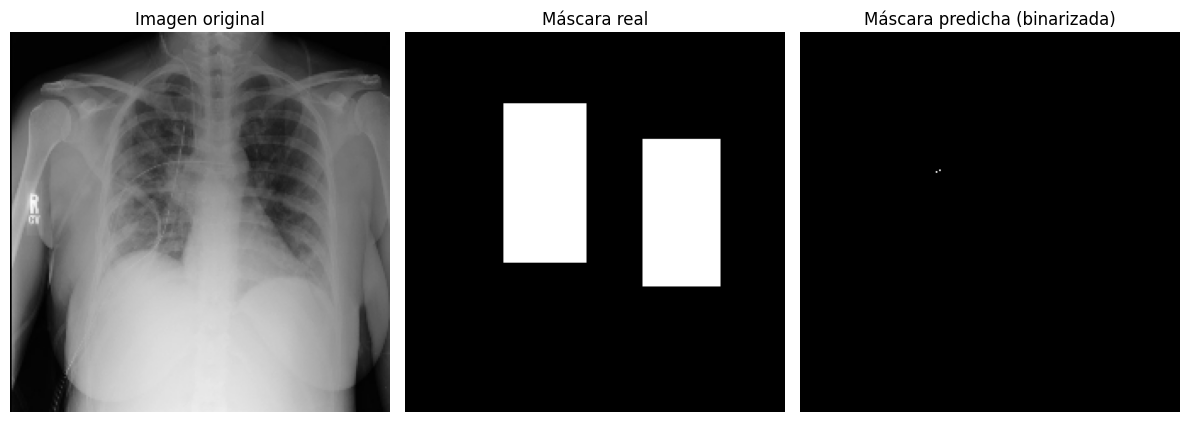

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


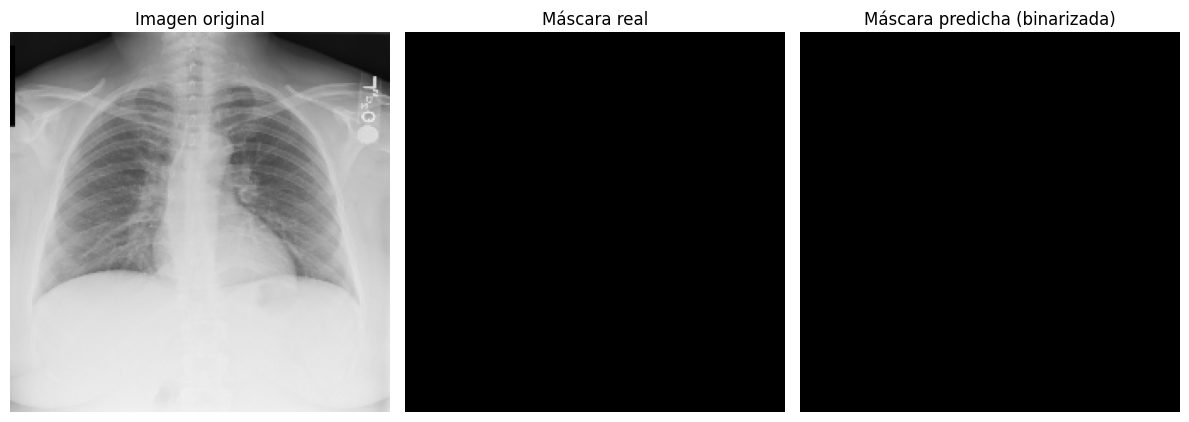

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


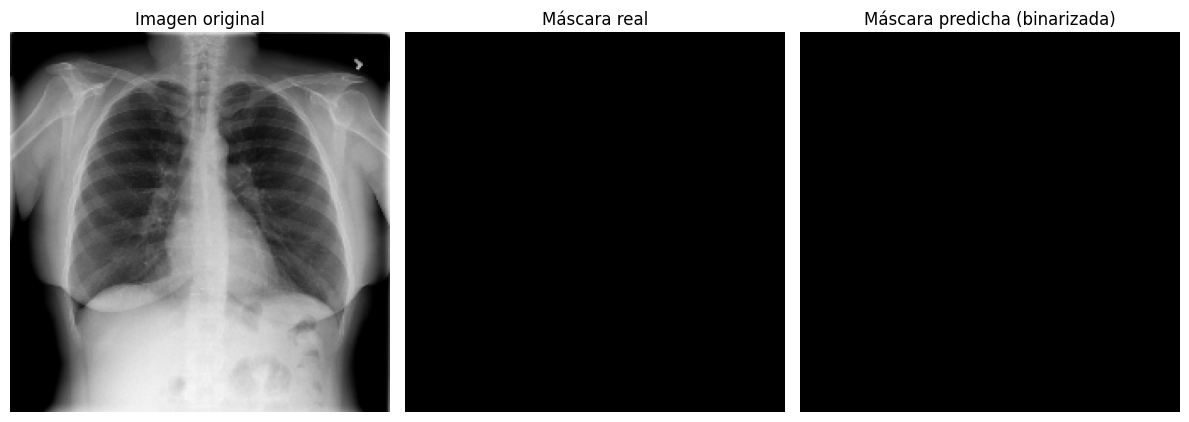

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


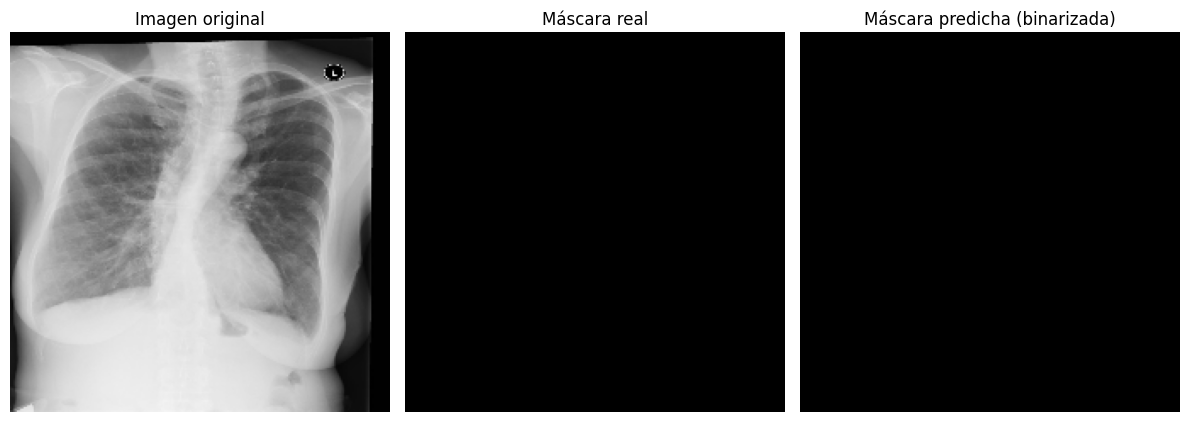

Target real: 0, Target predicho: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


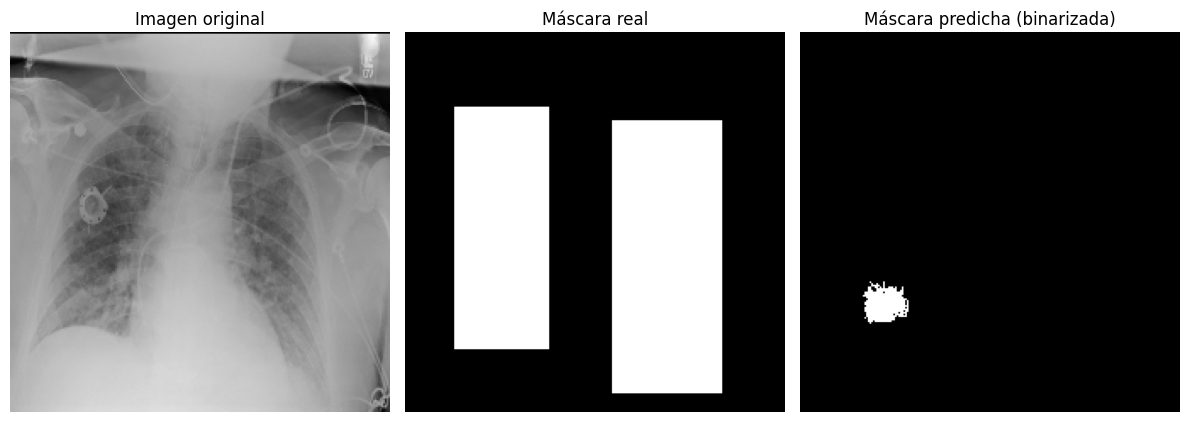

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


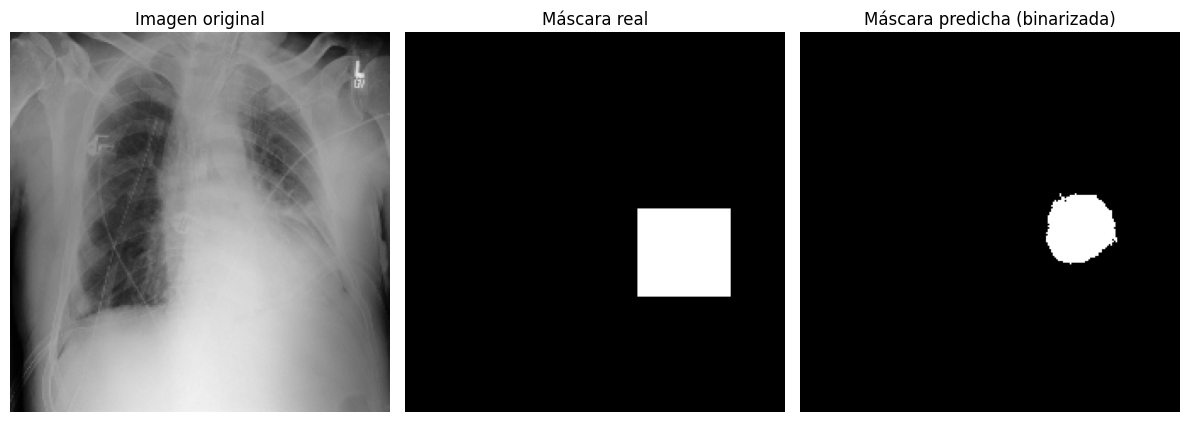

Target real: 1, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


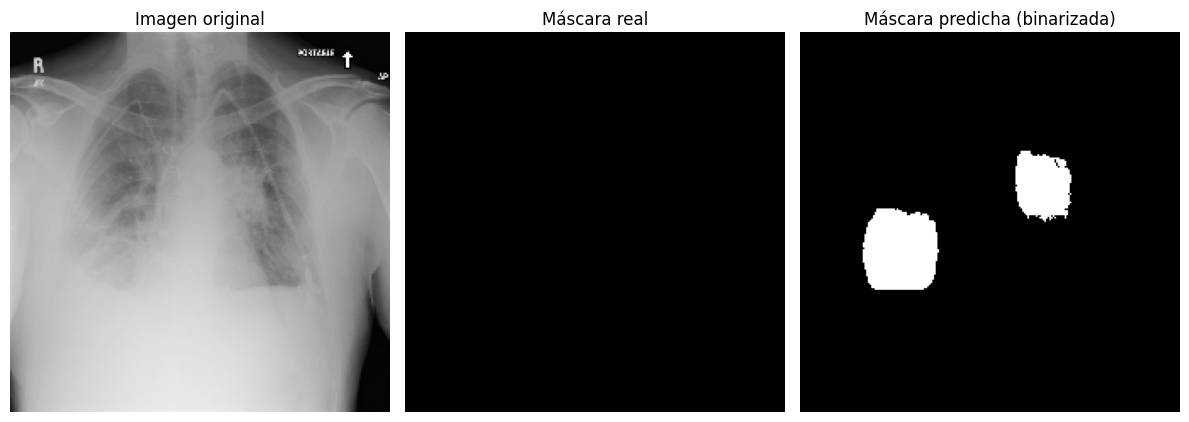

Target real: 0, Target predicho: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


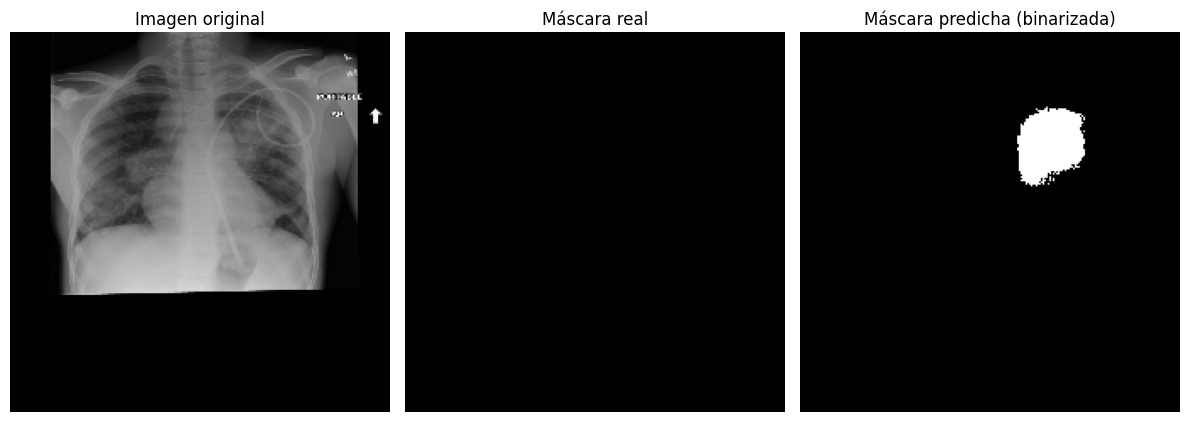

Target real: 0, Target predicho: 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=1, threshold=0.5):
    """
    Función para visualizar las imágenes, máscaras reales y predichas.

    Parámetros:
    - model: El modelo entrenado de Keras.
    - dataset: El conjunto de datos de prueba (tf.data.Dataset).
    - num_samples: El número de muestras que se mostrarán (por defecto 1).
    - threshold: Umbral para binarizar la máscara predicha (por defecto 0.5).
    """

    # Tomamos el número de muestras especificado
    for (image, var), (masks, targets) in dataset.take(1):  # Tomar solo un batch
        for i in range(num_samples):  # Iterar sobre cada imagen en el batch
            # Realizar la predicción
            pred_mask, pred_target = model.predict([image[i:i+1], var[i:i+1]])

            # Convertir la imagen al formato uint8 para visualizarla correctamente
            img_to_show = (image[i].numpy() * 255).astype(np.uint8)

            # Binarizar la máscara predicha usando el umbral
            binarized_mask = (pred_mask[0] > threshold).astype(np.float32)  # Convertir a binario

            # Visualizar las imágenes y las máscaras reales y predichas
            plt.figure(figsize=(12, 8))

            # Imagen original
            plt.subplot(1, 3, 1)
            plt.imshow(img_to_show)  # Mostrar la imagen escalada a [0, 255]
            plt.title('Imagen original')
            plt.axis('off')

            # Máscara real
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')  # Asegurarse de que la máscara sea 2D
            plt.title('Máscara real')
            plt.axis('off')

            # Máscara predicha binarizada
            plt.subplot(1, 3, 3)
            plt.imshow(binarized_mask.squeeze(), cmap='gray')  # Asegurarse de que la predicción sea 2D
            plt.title('Máscara predicha (binarizada)')
            plt.axis('off')

            # Mostrar el gráfico
            plt.tight_layout()
            plt.show()

            # Mostrar el valor predicho del target binario
            print(f"Target real: {targets[i].numpy()}, Target predicho: {int(pred_target[0] > 0.5)}")

# Llama a la función con num_samples = 15
visualize_predictions(model, test_dataset, num_samples=15)
